In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ziesel/GSE60361_C1-3005-Expression.txt


In [19]:
!pip install scikit-misc


In [20]:
pip install leidenalg

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [22]:
!pip install scanpy

In [23]:
pip install scanpy matplotlib seaborn pandas numpy


Note: you may need to restart the kernel to use updated packages.


In [24]:
#Imports
import itertools
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


No annotation file found or error attaching labels. Proceeding without labels.
=== Dataset Overview ===
Shape (Cells x Genes): (19972, 3005)
First 5 Cell IDs: ['Tspan12', 'Tshz1', 'Fnbp1l', 'Adamts15', 'Cldn12']
First 5 Gene Names: ['1772071015_C02', '1772071017_G12', '1772071017_A05', '1772071014_B06', '1772067065_H06']

Sparsity of expression matrix: 81.21%

=== Summary statistics for first 5 genes ===
                    mean        std  min  25%  50%  75%     max
1772071015_C02  1.080513   7.843994  0.0  0.0  0.0  0.0   822.0
1772071017_G12  1.088924   7.990756  0.0  0.0  0.0  0.0   869.0
1772071017_A05  1.584318  10.728301  0.0  0.0  0.0  1.0  1237.0
1772071014_B06  1.648007  11.922340  0.0  0.0  0.0  1.0  1252.0
1772067065_H06  1.078009   4.814648  0.0  0.0  0.0  0.0   271.0


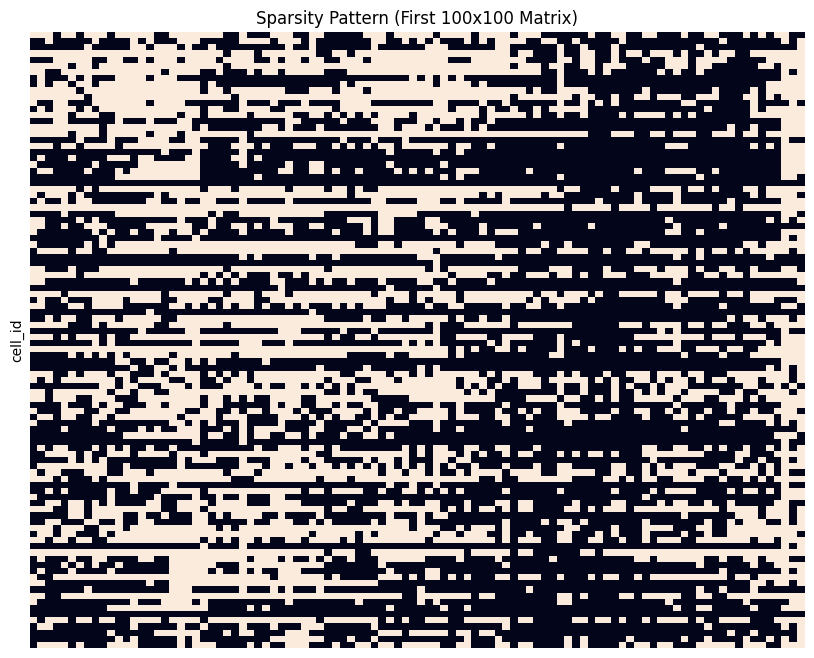

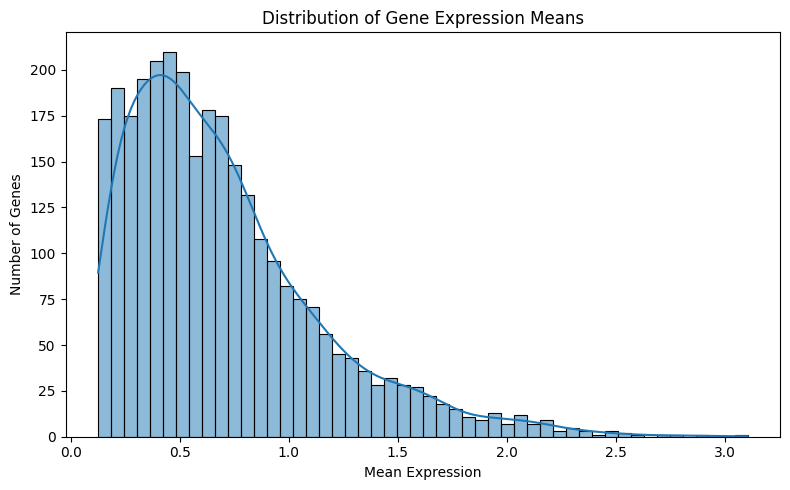


No cell type labels available, skipping class distribution plot.


In [25]:

# Loading the gene expression matrix 
df = pd.read_csv("/kaggle/input/ziesel/GSE60361_C1-3005-Expression.txt", sep="\t", index_col=0)

if df.shape[0] < df.shape[1]:
    df = df.T

adata = sc.AnnData(df)

adata.obs_names_make_unique()

adata.write("GSE60361_mouse_cortex_data.h5ad")

try:
    labels = pd.read_csv("GSE60361_cell_metadata.csv", index_col=0)
    # Ensure that the index matches the cell names in adata
    if not labels.index.isin(adata.obs_names).all():
        labels = labels.loc[adata.obs_names]
    adata.obs['label'] = labels['cell_type']
    has_labels = True
except Exception as e:
    print("No annotation file found or error attaching labels. Proceeding without labels.")
    has_labels = False

if has_labels:
    adata.write("GSE60361_mouse_cortex_data_labeled.h5ad")
# QC & Summary Statistics 
print("=== Dataset Overview ===")
print(f"Shape (Cells x Genes): {adata.shape}")
print(f"First 5 Cell IDs: {adata.obs_names[:5].tolist()}")
print(f"First 5 Gene Names: {adata.var_names[:5].tolist()}")

# Sparsity check
num_zeros = (adata.X == 0).sum()
total = adata.X.size
sparsity = num_zeros / total
print(f"\nSparsity of expression matrix: {sparsity * 100:.2f}%")

# Per-gene summary
summary_stats = df.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
print("\n=== Summary statistics for first 5 genes ===")
print(summary_stats.head())

# Sparsity Heatmap 
subset = df.iloc[:100, :100]
plt.figure(figsize=(10, 8))
sns.heatmap((subset == 0), cbar=False, xticklabels=False, yticklabels=False)
plt.title("Sparsity Pattern (First 100x100 Matrix)")
plt.show()

# Gene Mean Distribution
gene_means = df.mean(axis=0)
plt.figure(figsize=(8, 5))
sns.histplot(gene_means, bins=50, kde=True)
plt.title("Distribution of Gene Expression Means")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

#  Class Imbalance Check:
if has_labels:
    label_counts = adata.obs["label"].value_counts().sort_index()
    label_counts.index = label_counts.index.astype(str)

    print("\n=== Class Distribution (First 10 Classes) ===")
    print(label_counts.head(10))

    plt.figure(figsize=(12, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title("Class Distribution of Cell Types")
    plt.xlabel("Class Label")
    plt.ylabel("Number of Cells")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo cell type labels available, skipping class distribution plot.")


Number of mitochondrial genes detected: 0
Example mitochondrial genes: []


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


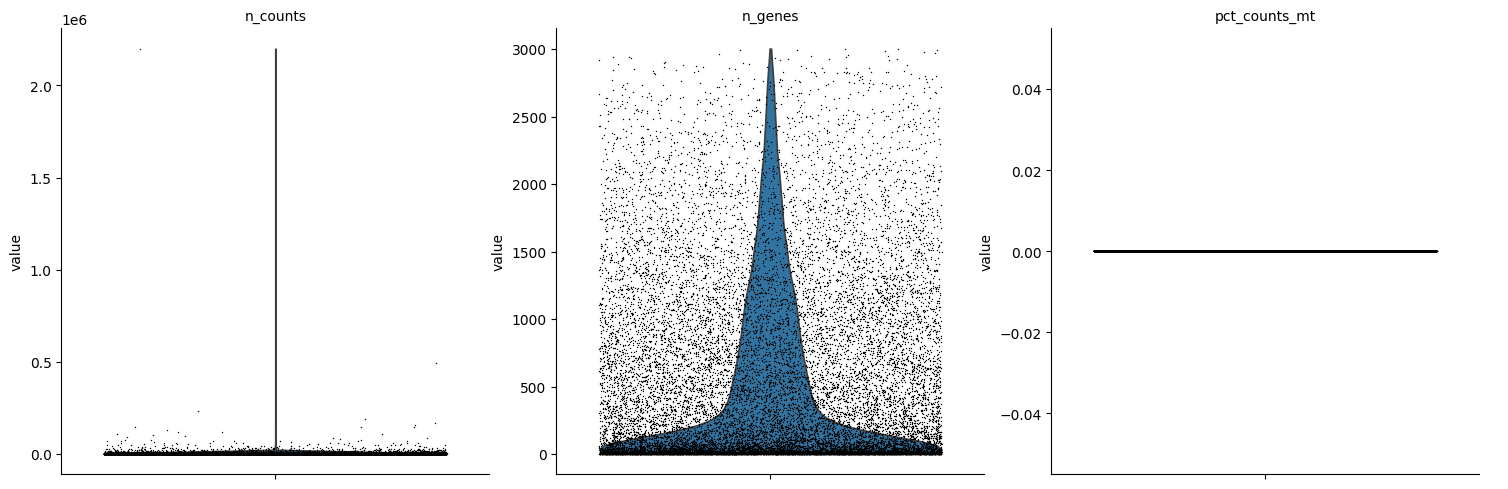

Before filtering: (19972, 3005)


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


After filtering: (8983, 3005)
HVGs selected: 2000


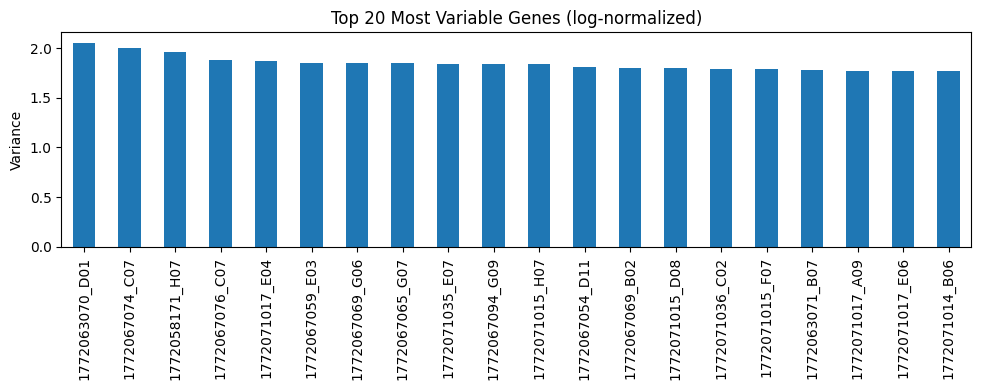

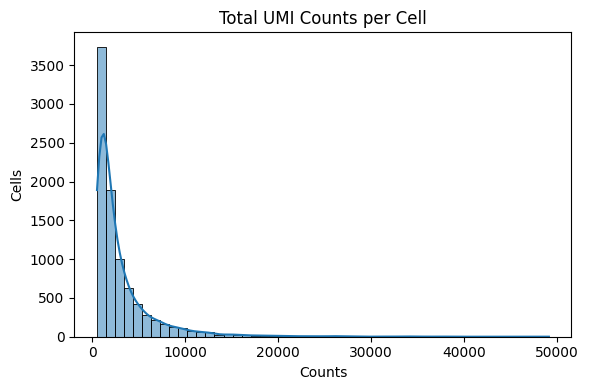

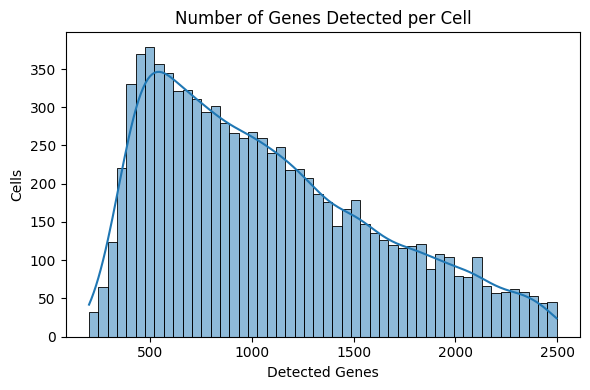

Filtered raw Zeisel dataset saved 
- Log-normalized dataset saved


In [26]:

adata = sc.read("GSE60361_mouse_cortex_data.h5ad")  # Replace with your filename if different

# Calculating QC metrics:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if sparse.issparse(adata.X) else adata.X.sum(axis=1)
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=1)
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).A1 if sparse.issparse(adata.X) else (adata.X > 0).sum(axis=0)

#  Mitochondrial Gene Detection 

mt_gene_mask = adata.var_names.str.lower().str.startswith('mt-')
print(f"Number of mitochondrial genes detected: {mt_gene_mask.sum()}")
print("Example mitochondrial genes:", adata.var_names[mt_gene_mask][:5].tolist())
adata.var['mt'] = mt_gene_mask

# Calculating pct_counts_mt :
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

#  Visualizing QC metrics 
sc.pl.violin(adata, ['n_counts', 'n_genes', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

#  Filtering 
print(f"Before filtering: {adata.shape}")

# Filter cells: min & max for counts and genes
adata = adata[(adata.obs['n_counts'] >= 500) & (adata.obs['n_counts'] < 50000), :]
adata = adata[(adata.obs['n_genes'] >= 200) & (adata.obs['n_genes'] < 2500), :]

# Filter cells: mitochondrial content < 5%
adata = adata[adata.obs['pct_counts_mt'] < 5, :]

# Filter genes: keep genes expressed in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

print(f"After filtering: {adata.shape}")

# Saving filtered raw counts:
adata_raw = adata.copy()
adata_raw.write("zeisel_mouse_raw_for_scdcc.h5ad")

# Log-normalize:
adata_eda = adata.copy()
sc.pp.normalize_total(adata_eda, target_sum=1e4)
sc.pp.log1p(adata_eda)

# Highly variable genes:
sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor='seurat', inplace=True)
print(f"HVGs selected: {adata_eda.var.highly_variable.sum()}")

# Ploting top HVGs:
top_hvg = adata_eda[:, adata_eda.var.highly_variable].to_df().var().sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 4))
top_hvg.plot(kind='bar')
plt.title("Top 20 Most Variable Genes (log-normalized)")
plt.ylabel("Variance")
plt.tight_layout()
plt.show()

# Ploting UMI count distribution:
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_counts'], bins=50, kde=True)
plt.title("Total UMI Counts per Cell")
plt.xlabel("Counts")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Ploting gene detection per cell:
plt.figure(figsize=(6, 4))
sns.histplot(adata.obs['n_genes'], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Detected Genes")
plt.ylabel("Cells")
plt.tight_layout()
plt.show()

# Saving log-normalized 
adata_eda.write("zeisel_mouse_eda_log_norm.h5ad")

print("Filtered raw Zeisel dataset saved ")
print("- Log-normalized dataset saved")


Shape after transpose: (3005, 8983)
First cells: Index(['1772071015_C02', '1772071017_G12', '1772071017_A05', '1772071014_B06',
       '1772067065_H06'],
      dtype='object', name='cell_id')
First genes: Index(['Tspan12', 'Tshz1', 'Fnbp1l', 'Cldn12', 'Sema3c'], dtype='object', name='gene_symbol')
Trying Leiden resolutions 0.2 to 2.0 in steps of 0.05...
Resolution: 0.20 --> 5 clusters
Resolution: 0.25 --> 5 clusters
Resolution: 0.30 --> 6 clusters
Resolution: 0.35 --> 8 clusters
Resolution: 0.40 --> 9 clusters
Resolution: 0.45 --> 9 clusters
Resolution: 0.50 --> 11 clusters
Resolution: 0.55 --> 12 clusters
Resolution: 0.60 --> 13 clusters
Resolution: 0.65 --> 14 clusters
Resolution: 0.70 --> 15 clusters
Resolution: 0.75 --> 15 clusters
Resolution: 0.80 --> 16 clusters
Resolution: 0.85 --> 16 clusters
Resolution: 0.90 --> 16 clusters
Resolution: 0.95 --> 17 clusters
Resolution: 1.00 --> 19 clusters
Resolution: 1.05 --> 19 clusters
Resolution: 1.10 --> 19 clusters
Resolution: 1.15 --> 19

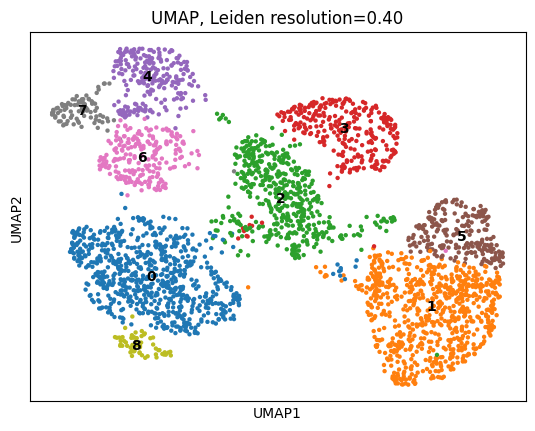

Markers found in dataset: 17 / 28


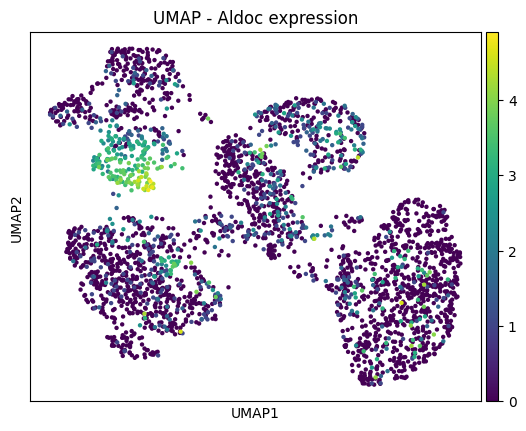

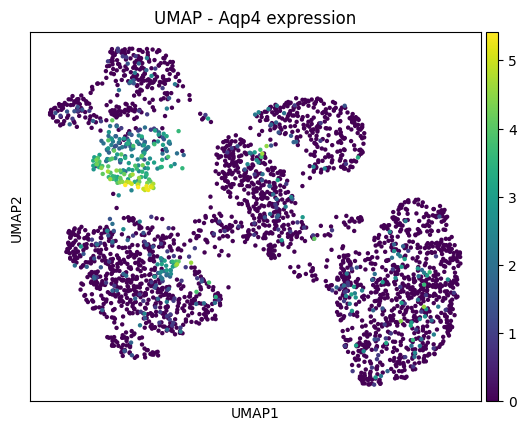

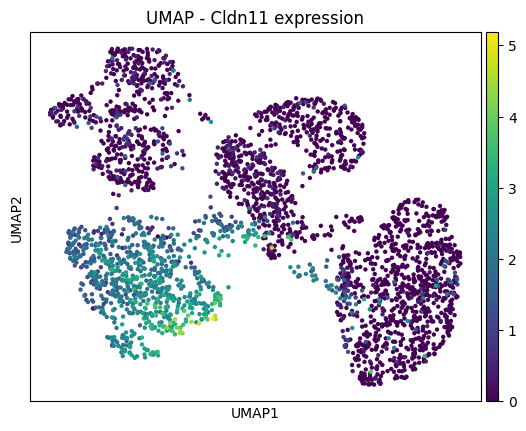

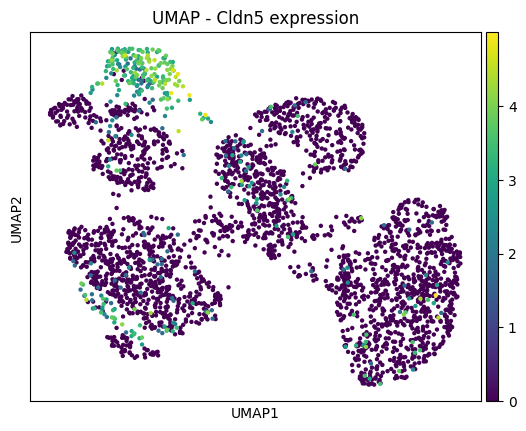

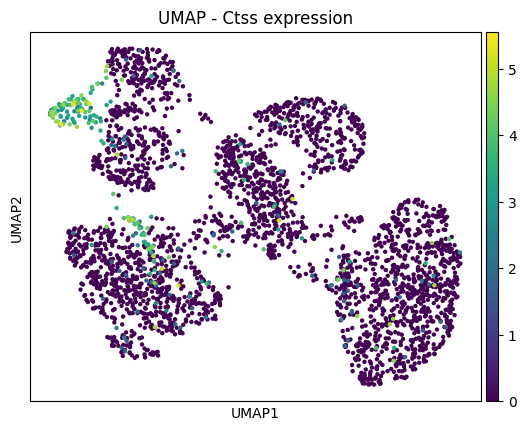

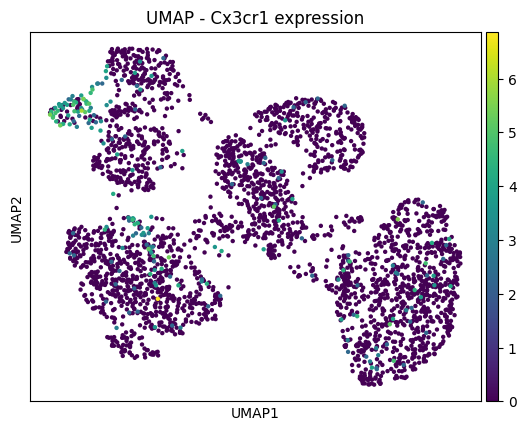

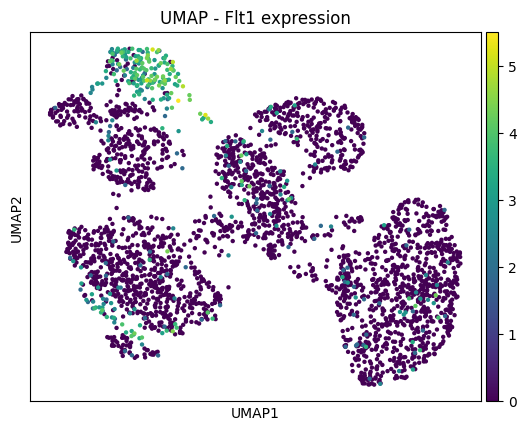

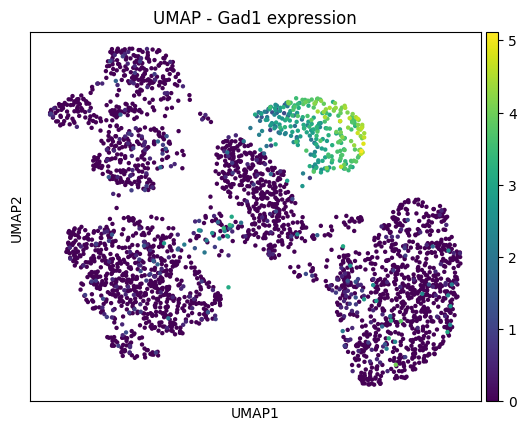

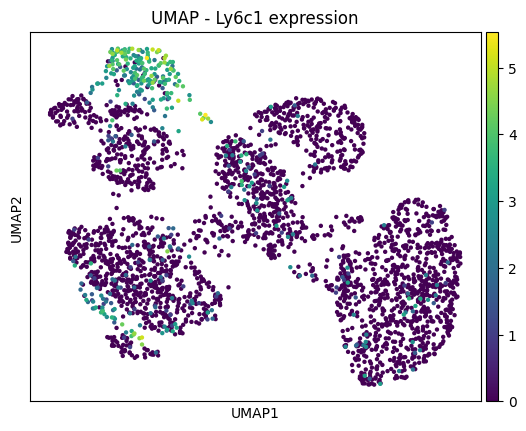

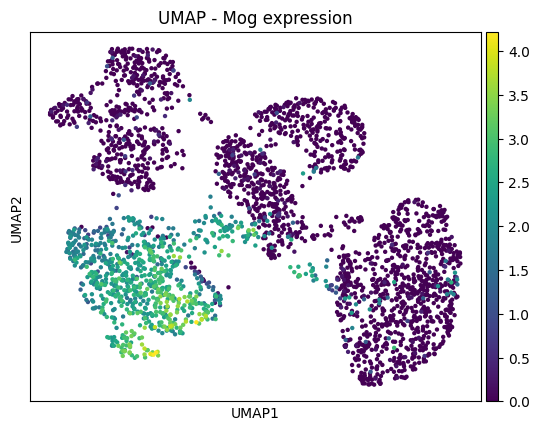

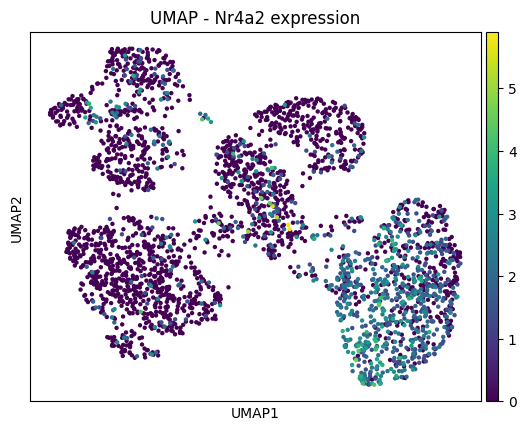

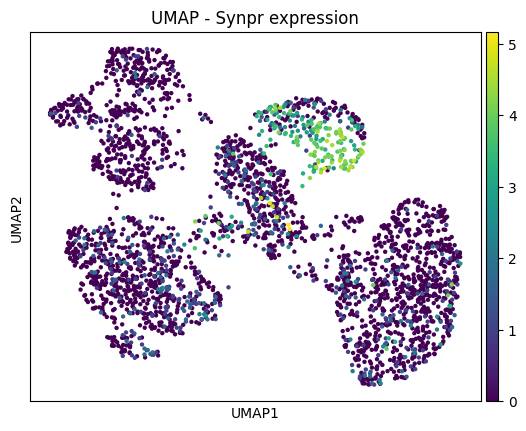

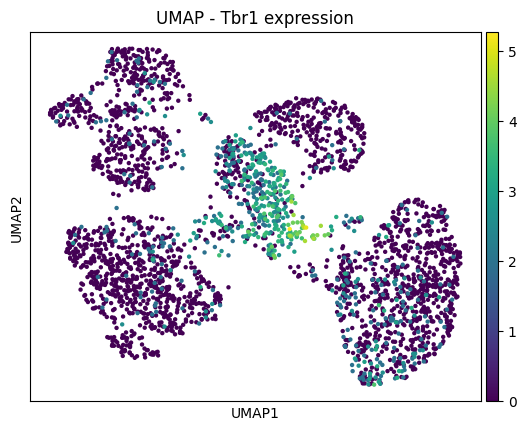

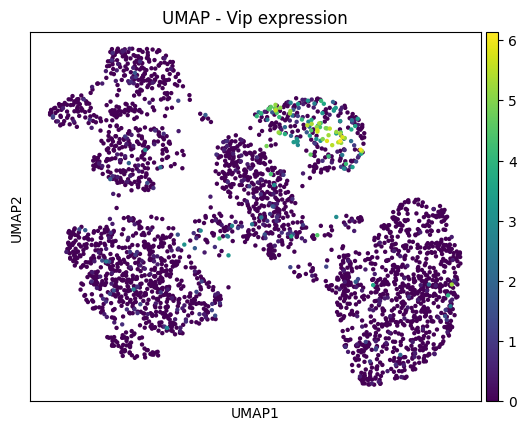

/tmp/ipykernel_36/3748033210.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/3748033210.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/3748033210.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war


Assigned cell types by marker gene expression per cluster:
  Cluster 0: Oligodendrocyte
  Cluster 1: Neurons
  Cluster 2: Neurons
  Cluster 3: Interneurons
  Cluster 4: Endothelial
  Cluster 5: Neurons
  Cluster 6: Astrocyte
  Cluster 7: Microglia
  Cluster 8: Oligodendrocyte


/tmp/ipykernel_36/3748033210.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()


 Finished. Leiden clustering and marker-based annotation saved.


In [27]:

adata_eda = sc.read("zeisel_mouse_eda_log_norm.h5ad")

adata_eda = adata_eda.T

adata_eda.obs_names.name = 'cell_id'
adata_eda.var_names.name = 'gene_symbol'

# Making sure gene names are unique
adata_eda.var_names_make_unique()

#  Quick sanity check 
print(f"Shape after transpose: {adata_eda.shape}")       
print("First cells:", adata_eda.obs_names[:5])
print("First genes:", adata_eda.var_names[:5])

#  PCA / neighbors / UMAP 
sc.tl.pca(adata_eda, svd_solver='arpack')
sc.pp.neighbors(adata_eda, n_pcs=50, n_neighbors=15)
sc.tl.umap(adata_eda)

#  Searching for Leiden resolution 
target_n = 9
best_res = None
best_diff = 999
cluster_counts = {}

print("Trying Leiden resolutions 0.2 to 2.0 in steps of 0.05...")
for res in np.arange(0.2, 2.05, 0.05):
    sc.tl.leiden(adata_eda, resolution=res, key_added=f'leiden_{res:.2f}')
    n_clusters = adata_eda.obs[f'leiden_{res:.2f}'].nunique()
    cluster_counts[res] = n_clusters
    diff = abs(n_clusters - target_n)
    if diff < best_diff:
        best_diff = diff
        best_res = res
    print(f"Resolution: {res:.2f} --> {n_clusters} clusters")

print(f"\nBest resolution for ~{target_n} clusters: {best_res:.2f} ({cluster_counts[best_res]} clusters)")

#  Seting chosen cluster column 
best_leiden_key = f'leiden_{best_res:.2f}'
adata_eda.obs['cluster'] = adata_eda.obs[best_leiden_key]

#  UMAP plot of these clusters 
sc.pl.umap(
    adata_eda,
    color='cluster',
    legend_loc='on data',
    title=f"UMAP, Leiden resolution={best_res:.2f}"
)

#  Marker genes for annotation
marker_dict = {
    "Astrocyte": ["Gfap", "Aqp4", "Aldoc"],
    "Microglia": ["Cx3cr1", "Ctss", "Tmem119"],
    "Oligodendrocyte": ["Plp1", "Mog", "Cldn11"],
    "Neurons": ["Snap25", "Rbfox3"],
    "Endothelial": ["Cldn5", "Flt1", "Ly6c1"],
    "Interneurons": ["Sst", "Pvalb", "Vip", "Gad1", "Calb2"],
    "Pyramidal": ["Tbr1", "Nr4a2", "Synpr", "Pcp4"],
    "Ependymal": ["Foxj1", "Rfx2"],
    "Mural": ["Acta2", "Rgs5", "Myh11"],
}

# Flattening markers and check which exist in dataset
all_marker_genes = sorted(
    set(g for genes in marker_dict.values() for g in genes if g in adata_eda.var_names)
)
print(f"Markers found in dataset: {len(all_marker_genes)} / {sum(len(v) for v in marker_dict.values())}")

# Plot expression of each found marker gene
for gene in all_marker_genes:
    sc.pl.umap(adata_eda, color=gene, title=f"UMAP - {gene} expression", show=True)

#  Computing average marker expression per cluster 
cluster_ids = sorted(adata_eda.obs['cluster'].unique())
cluster_marker_scores = pd.DataFrame(index=cluster_ids, columns=marker_dict.keys(), dtype=float)

for cell_type, markers in marker_dict.items():
    markers_in_data = [g for g in markers if g in adata_eda.var_names]
    if not markers_in_data:
        continue
    # Average the marker expression per cluster
    marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
    cluster_marker_scores.loc[marker_expr.index, cell_type] = marker_expr.mean(axis=1)

# Assigning cell type by highest marker score per cluster
cluster2type = cluster_marker_scores.idxmax(axis=1).to_dict()
adata_eda.obs['cell_type_marker'] = adata_eda.obs['cluster'].map(cluster2type).astype('category')

print("\nAssigned cell types by marker gene expression per cluster:")
for c in cluster2type:
    print(f"  Cluster {c}: {cluster2type[c]}")

#  UMAP with marker-based annotation 
sc.pl.umap(
    adata_eda,
    color='cell_type_marker',
    legend_loc='on data',
    title="UMAP by Marker Gene Cell Type Annotation"
)

# Saving the annotated data 
adata_eda.write("zeisel_mouse_eda_marker_annotated_9clusters.h5ad")
print(" Finished. Leiden clustering and marker-based annotation saved.")


In [28]:
# Runing DE test to find marker genes for each cluster
sc.tl.rank_genes_groups(adata_eda, groupby='cluster', method='wilcoxon')

# Ploting the results 
sc.pl.rank_genes_groups(adata_eda, groupby='cluster')


In [29]:

# Loading log-normalized Zeisel data
adata_eda = sc.read("zeisel_mouse_eda_log_norm.h5ad")
adata_eda = adata_eda.T  # rows=cells, cols=genes
adata_eda.obs_names.name = 'cell_id'
adata_eda.var_names.name = 'gene_symbol'
adata_eda.var_names_make_unique()

adata_raw = adata_eda.copy()

print(f" Loaded & transposed: {adata_eda.shape}")
print("First cells:", adata_eda.obs_names[:3].tolist())
print("First genes:", adata_eda.var_names[:3].tolist())

if "highly_variable" not in adata_eda.var.columns:
    # use 'seurat' (works fine on log-normalized); 'seurat_v3' expects raw counts
    sc.pp.highly_variable_genes(adata_eda, n_top_genes=2000, flavor="seurat")
adata_eda = adata_eda[:, adata_eda.var.highly_variable].copy()
print(f" HVG Subset Shape: {adata_eda.shape}")

label_key_candidates = ["label", "cell_type_marker", "cluster"]
label_key = next((k for k in label_key_candidates if k in adata_raw.obs.columns), None)

if label_key is None:
    # Make clusters on HVGs
    sc.tl.pca(adata_eda, svd_solver="arpack")
    sc.pp.neighbors(adata_eda, n_pcs=min(50, adata_eda.n_vars), n_neighbors=15)
    sc.tl.umap(adata_eda)
    sc.tl.leiden(adata_eda, resolution=1.0, key_added="cluster")

    # Copy cluster to adata_raw so both have the same labels
    adata_raw.obs["cluster"] = adata_eda.obs["cluster"].reindex(adata_raw.obs_names).values

    marker_dict = {
        "Astrocyte": ["Gfap", "Aqp4", "Aldoc"],
        "Microglia": ["Cx3cr1", "Ctss", "Tmem119"],
        "Oligodendrocyte": ["Plp1", "Mog", "Cldn11"],
        "Neurons": ["Snap25", "Rbfox3"],
        "Endothelial": ["Cldn5", "Flt1", "Ly6c1"],
        "Interneurons": ["Sst", "Pvalb", "Vip", "Gad1", "Calb2"],
        "Pyramidal": ["Tbr1", "Nr4a2", "Synpr", "Pcp4"],
        "Ependymal": ["Foxj1", "Rfx2"],
        "Mural": ["Acta2", "Rgs5", "Myh11"],
    }
    cluster_ids = sorted(adata_eda.obs['cluster'].unique())
    cluster_marker_scores = pd.DataFrame(index=cluster_ids, columns=marker_dict.keys(), dtype=float)

    for cell_type, markers in marker_dict.items():
        markers_in_data = [g for g in markers if g in adata_eda.var_names]
        if not markers_in_data:
            continue
        marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
        cluster_marker_scores.loc[marker_expr.index, cell_type] = marker_expr.mean(axis=1)

    if cluster_marker_scores.notna().any().any():
        cluster2type = cluster_marker_scores.idxmax(axis=1).to_dict()
        adata_eda.obs['cell_type_marker'] = adata_eda.obs['cluster'].map(cluster2type).astype('category')
        adata_raw.obs['cell_type_marker'] = adata_raw.obs['cluster'].map(cluster2type).astype('category')
        label_key = "cell_type_marker"
    else:
        label_key = "cluster"

print(f" Using labels from adata.obs['{label_key}']")

#  Sanity check: cell alignment 
assert np.all(adata_raw.obs_names == adata_eda.obs_names), "Mismatch in cell IDs!"

#  80/10/10 split 
indices = np.arange(adata_raw.n_obs)
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

#  Creating subset AnnData objects 
adata_raw_train = adata_raw[train_idx].copy()
adata_raw_val   = adata_raw[val_idx].copy()
adata_raw_test  = adata_raw[test_idx].copy()

adata_eda_train = adata_eda[train_idx].copy()
adata_eda_val   = adata_eda[val_idx].copy()
adata_eda_test  = adata_eda[test_idx].copy()

# Attaching labels to splits 
cell_to_label = adata_raw.obs[label_key].astype(str)

for ad, name in zip([adata_raw_train, adata_raw_val, adata_raw_test], ["Train","Val","Test"]):
    ad.obs["label"] = cell_to_label.loc[ad.obs_names].values
    print(f" Labels attached to {name} RAW split. Missing:", ad.obs["label"].isna().sum())

for ad_hvg, name in zip([adata_eda_train, adata_eda_val, adata_eda_test], ["Train","Val","Test"]):
    ad_hvg.obs["label"] = cell_to_label.loc[ad_hvg.obs_names].values
    print(f" Labels attached to HVG {name} split. Missing:", ad_hvg.obs["label"].isna().sum())

# summary
print("\n=== Raw-like (copied from Zeisel EDA) Splits ===")
print(f"Train: {adata_raw_train.shape}, {adata_raw_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_raw_val.shape}, {adata_raw_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_raw_test.shape}, {adata_raw_test.obs_names[:3].tolist()}")

print("\n=== HVG (Constraints) Splits ===")
print(f"Train: {adata_eda_train.shape}, {adata_eda_train.obs_names[:3].tolist()}")
print(f"Val:   {adata_eda_val.shape}, {adata_eda_val.obs_names[:3].tolist()}")
print(f"Test:  {adata_eda_test.shape}, {adata_eda_test.obs_names[:3].tolist()}")

# Saving DataSets
adata_raw_train.write("scdcc_rawish_train.h5ad")
adata_raw_val.write("scdcc_rawish_val.h5ad")
adata_raw_test.write("scdcc_rawish_test.h5ad")

adata_eda_train.write("constraints_hvg_train.h5ad")
adata_eda_val.write("constraints_hvg_val.h5ad")
adata_eda_test.write("constraints_hvg_test.h5ad")

print("\n All data splits saved with labels attached.")


 Loaded & transposed: (3005, 8983)
First cells: ['1772071015_C02', '1772071017_G12', '1772071017_A05']
First genes: ['Tspan12', 'Tshz1', 'Fnbp1l']
 HVG Subset Shape: (3005, 2000)


/tmp/ipykernel_36/2850164043.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/2850164043.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  marker_expr = adata_eda[:, markers_in_data].to_df().groupby(adata_eda.obs['cluster']).mean()
/tmp/ipykernel_36/2850164043.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this war

 Using labels from adata.obs['cell_type_marker']
 Labels attached to Train RAW split. Missing: 0
 Labels attached to Val RAW split. Missing: 0
 Labels attached to Test RAW split. Missing: 0
 Labels attached to HVG Train split. Missing: 0
 Labels attached to HVG Val split. Missing: 0
 Labels attached to HVG Test split. Missing: 0

=== Raw-like (copied from Zeisel EDA) Splits ===
Train: (2404, 8983), ['1772062109_D05', '1772067093_G11', '1772067094_E03']
Val:   (300, 8983), ['1772071036_B11', '1772067060_B09', '1772062116_F01']
Test:  (301, 8983), ['1772071014_F02', '1772066097_A05', '1772067066_D04']

=== HVG (Constraints) Splits ===
Train: (2404, 2000), ['1772062109_D05', '1772067093_G11', '1772067094_E03']
Val:   (300, 2000), ['1772071036_B11', '1772067060_B09', '1772062116_F01']
Test:  (301, 2000), ['1772071014_F02', '1772066097_A05', '1772067066_D04']


... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical
... storing 'label' as categorical



 All data splits saved with labels attached.


In [30]:

adata = sc.read("constraints_hvg_train.h5ad")

#Check for labels 
if 'label' not in adata.obs.columns:
    raise ValueError(" adata.obs['label'] not found. Please attach true labels before running this.")

# === Group cells by label ===
label_groups = adata.obs.groupby('label').groups  # label → list of cell IDs

# Prompt user for total constraint sizes
user_input = input(" Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000): ")
constraint_sizes = [int(x.strip()) for x in user_input.split(",") if x.strip().isdigit()]
print(f"\n Will generate constraints for TOTAL sizes: {constraint_sizes}")

def generate_constraints(label_groups, total_constraints, seed=42):
    random.seed(seed)
    labels = list(label_groups.keys())
    must_link = set()
    cannot_link = set()
    n_ml = total_constraints // 2 + total_constraints % 2  # if odd, must-link gets extra
    n_cl = total_constraints // 2

    # Must-link: pairs from same class
    while len(must_link) < n_ml:
        label = random.choice(labels)
        members = list(label_groups[label])
        if len(members) >= 2:
            pair = tuple(sorted(random.sample(members, 2)))
            must_link.add(pair)

    # Cannot-link: pairs from different classes
    while len(cannot_link) < n_cl:
        l1, l2 = random.sample(labels, 2)
        if l1 == l2:
            continue
        i = random.choice(label_groups[l1])
        j = random.choice(label_groups[l2])
        pair = tuple(sorted((i, j)))
        if pair not in must_link:  # Don't allow overlap
            cannot_link.add(pair)

    return list(must_link), list(cannot_link)

#  Generate and store constraints in-memory 
constraints = {}

for total_size in constraint_sizes:
    ml, cl = generate_constraints(label_groups, total_constraints=total_size)
    constraints[total_size] = {
        "must_link": ml,
        "cannot_link": cl
    }
    print(f"\n Constraints generated for total size {total_size}:")
    print(f"    Must-link pairs:    {len(ml)}")
    print(f"    Cannot-link pairs:  {len(cl)}")


/tmp/ipykernel_36/777957030.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  label_groups = adata.obs.groupby('label').groups  # label → list of cell IDs


 Enter TOTAL constraint sizes (comma-separated, e.g., 100,500,1000):  0,1000,2000,3000,4000,5000,6000



 Will generate constraints for TOTAL sizes: [0, 1000, 2000, 3000, 4000, 5000, 6000]

 Constraints generated for total size 0:
    Must-link pairs:    0
    Cannot-link pairs:  0

 Constraints generated for total size 1000:
    Must-link pairs:    500
    Cannot-link pairs:  500

 Constraints generated for total size 2000:
    Must-link pairs:    1000
    Cannot-link pairs:  1000

 Constraints generated for total size 3000:
    Must-link pairs:    1500
    Cannot-link pairs:  1500

 Constraints generated for total size 4000:
    Must-link pairs:    2000
    Cannot-link pairs:  2000

 Constraints generated for total size 5000:
    Must-link pairs:    2500
    Cannot-link pairs:  2500

 Constraints generated for total size 6000:
    Must-link pairs:    3000
    Cannot-link pairs:  3000


Integer label mapping (for metrics):
0: Astrocyte
1: Pyramidal
2: Interneurons
3: Microglia
4: Oligodendrocyte
5: Endothelial
6: Mural
 KMeans Baseline Evaluation
 ARI: 0.4582
 NMI: 0.5966
 CA:  0.6445


... storing 'true_label' as categorical
... storing 'kmeans_pred' as categorical



 PCA & UMAP of KMeans Predictions


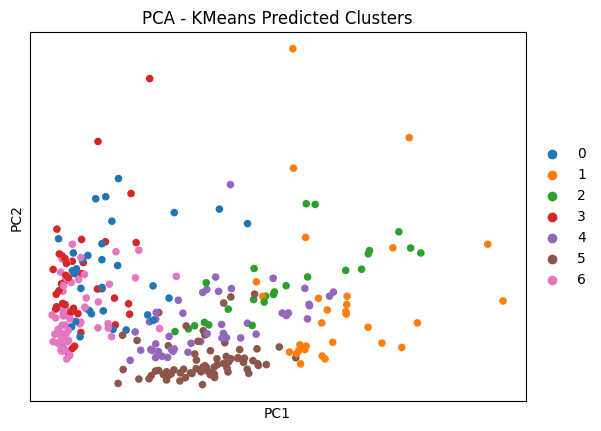

In [31]:

#Loading HVG log-normalized training and test data 
adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad")  # same features (2000 HVGs)

# Extracting matrices and true labels 
X_train = adata_train.X
X_test = adata_test.X

true_labels, unique_types = pd.factorize(adata_test.obs["label"].astype(str).values)
n_clusters = len(np.unique(true_labels))

print("Integer label mapping (for metrics):")
for i, name in enumerate(unique_types):
    print(f"{i}: {name}")

#Training KMeans on training set 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_train)

#Predict test labels 
pred_labels = kmeans.predict(X_test)

# Clustering Accuracy 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

# === Step 6: Compute Metrics ===
ari_kmeans = adjusted_rand_score(true_labels, pred_labels)
nmi_kmeans = normalized_mutual_info_score(true_labels, pred_labels)
ca_kmeans = clustering_accuracy(true_labels, pred_labels)

# === Step 7: Save results ===
kmeans_results = {
    "ARI": ari_kmeans,
    "NMI": nmi_kmeans,
    "CA": ca_kmeans,
    "true_labels": true_labels,
    "pred_labels": pred_labels
}

#Metrics
print(" KMeans Baseline Evaluation")
print(f" ARI: {ari_kmeans:.4f}")
print(f" NMI: {nmi_kmeans:.4f}")
print(f" CA:  {ca_kmeans:.4f}")

adata_vis = adata_test.copy()

adata_vis.obs["true_label"] = pd.Series(true_labels, index=adata_vis.obs_names).astype(str)
adata_vis.obs["kmeans_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)

#  Dimensionality Reduction 
sc.pp.pca(adata_vis, n_comps=50)
sc.pp.neighbors(adata_vis)
sc.tl.umap(adata_vis)

#  Visualizing predicted KMeans clusters 
print("\n PCA & UMAP of KMeans Predictions")
sc.pl.pca(
    adata_vis,
    color="kmeans_pred",
    title="PCA - KMeans Predicted Clusters",
    size=120,
    show=True
)

sc.pl.umap(
    adata_vis,
    color="kmeans_pred",
    title="UMAP - KMeans Predicted Clusters",
    size=120,
    show=True
)


Integer label mapping (for metrics):
0: Astrocyte
1: Pyramidal
2: Interneurons
3: Microglia
4: Oligodendrocyte
5: Endothelial
6: Mural
Training shape: (2404, 2000), Test shape: (301, 2000), Clusters: 7
 Pretraining Autoencoder...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 1.2994
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1169
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0977
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0757
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0378
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0287
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0348
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0251
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0003
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9645
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9685
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10

... storing 'dec_pred' as categorical


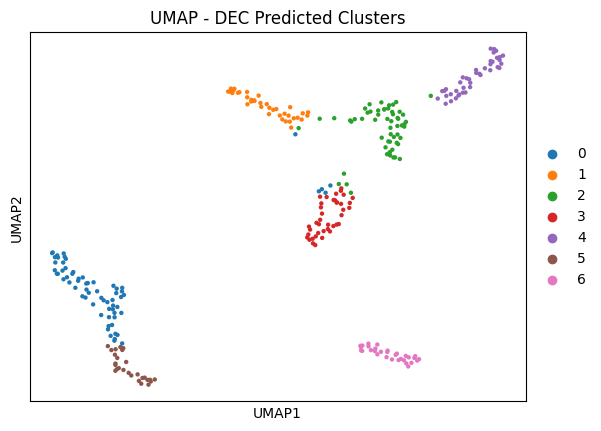

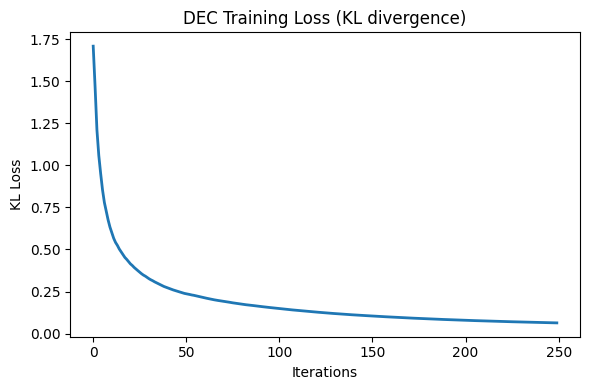

In [32]:

#Loading Data
adata_train = sc.read("constraints_hvg_train.h5ad")
adata_test = sc.read("constraints_hvg_test.h5ad")

X_train = adata_train.X.astype(np.float32)
X_test = adata_test.X.astype(np.float32)
true_labels, unique_types = pd.factorize(adata_test.obs["label"].astype(str).values)
n_clusters = len(np.unique(true_labels))

print("Integer label mapping (for metrics):")
for i, name in enumerate(unique_types):
    print(f"{i}: {name}")

print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}, Clusters: {n_clusters}")

# Clustering Accuracy 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

#  Autoencoder Definition & Pretrain 
input_dim = X_train.shape[1]
encoding_dim = 10

input_layer = Input(shape=(input_dim,))
encoded = Dense(500, activation='relu')(input_layer)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(2000, activation='relu')(encoded)
latent = Dense(encoding_dim, name='latent')(encoded)

decoded = Dense(2000, activation='relu')(latent)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(500, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=latent)

autoencoder.compile(optimizer='adam', loss='mse')
print(" Pretraining Autoencoder...")
autoencoder.fit(X_train, X_train, batch_size=256, epochs=50, verbose=1)

#KMeans Init 
Z_train = encoder.predict(X_train)
Z_test = encoder.predict(X_test)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans.fit(Z_train)
cluster_centers = kmeans.cluster_centers_

#  Clustering Layer 
class ClusteringLayer(tf.keras.layers.Layer):
    def __init__(self, n_clusters, initial_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = initial_weights

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.clusters = self.add_weight(
            shape=(self.n_clusters, input_dim),
            initializer='glorot_uniform',
            name='clusters'
        )
        if self.initial_weights is not None:
            self.set_weights([self.initial_weights.astype(np.float32)])
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        # Student’s t-distribution
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = q ** ((self.n_clusters + 1.0) / 2.0)
        q_sum = tf.reduce_sum(q, axis=1, keepdims=True)
        q = q / (q_sum + 1e-8)  # Protects against division by zero
        q = tf.clip_by_value(q, 1e-8, 1.0)
        return q

# Targeting Distribution 
def target_distribution(q, eps=1e-8):
    q = np.clip(q, eps, 1.0)
    weight = q ** 2 / (np.sum(q, axis=0, keepdims=True) + eps)
    p = (weight.T / (np.sum(weight, axis=1) + eps)).T
    return p

#  Building DEC Model 
clustering_layer = ClusteringLayer(n_clusters, initial_weights=cluster_centers, name='clustering')(encoder.output)
dec_model = Model(inputs=encoder.input, outputs=clustering_layer)
dec_model.compile(optimizer='adam', loss='kld')

#KL Fine-tuning 
print(" Fine-tuning DEC with KL divergence...")
maxiter = 5000
update_interval = 50
tol = 1e-4
min_kl_updates = 2  # Stop after 2 consecutive below-tol
kl_no_change = 0
batch_size = 256
loss_history = []
index_array = np.arange(X_train.shape[0])

q = dec_model.predict(X_train, verbose=0)
assert np.isfinite(q).all(), "NaNs in initial q!"
p = target_distribution(q)
assert np.isfinite(p).all(), "NaNs in initial p!"
y_pred_last = q.argmax(1)

for ite in range(maxiter):
    if ite % update_interval == 0:
        q = dec_model.predict(X_train, verbose=0)
        if not np.isfinite(q).all():
            print(f"NaNs detected in q at iter {ite}")
            print("q stats: min", np.nanmin(q), "max", np.nanmax(q))
            break
        p = target_distribution(q)
        if not np.isfinite(p).all():
            print(f"NaNs detected in p at iter {ite}")
            print("p stats: min", np.nanmin(p), "max", np.nanmax(p))
            break
        y_pred = q.argmax(1)
        label_change_rate = np.mean(y_pred != y_pred_last)
        print(f"Iter {ite}, Label change rate: {label_change_rate:.5f}")
        if label_change_rate < tol:
            kl_no_change += 1
            if kl_no_change >= min_kl_updates:
                print(f"Converged (label change rate < tol for {min_kl_updates} consecutive intervals).")
                break
        else:
            kl_no_change = 0
        y_pred_last = y_pred
    # Batch update
    idx = np.random.choice(index_array, batch_size, replace=False)
    loss = dec_model.train_on_batch(X_train[idx], p[idx])
    loss_history.append(float(loss))

#  Evaluating on Test Set 
q_test = dec_model.predict(X_test)
pred_labels = q_test.argmax(1)
ari = adjusted_rand_score(true_labels, pred_labels)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
ca = clustering_accuracy(true_labels, pred_labels)

print("\n DEC (with KL fine-tuning) Evaluation")
print(f" ARI: {ari:.4f}")
print(f" NMI: {nmi:.4f}")
print(f" CA:  {ca:.4f}")

# Saving results 
dec_results = {
    "ARI": ari,
    "NMI": nmi,
    "CA": ca,
    "true_labels": true_labels,
    "pred_labels": pred_labels,
    "kl_loss_history": loss_history,
}

# UMAP Visualization 
adata_vis = adata_test.copy()
adata_vis.obsm["X_latent"] = encoder.predict(X_test)
adata_vis.obs["dec_pred"] = pd.Series(pred_labels, index=adata_vis.obs_names).astype(str)
sc.pp.neighbors(adata_vis, use_rep="X_latent")
sc.tl.umap(adata_vis)
sc.pl.umap(adata_vis, color="dec_pred", title="UMAP - DEC Predicted Clusters", size=40)

#  KL Loss Curve 
plt.figure(figsize=(6, 4))
plt.plot(loss_history, lw=2)
plt.title("DEC Training Loss (KL divergence)")
plt.xlabel("Iterations")
plt.ylabel("KL Loss")
plt.tight_layout()
plt.show()


In [33]:


#  DEVICE SETUP 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  UTILS 
def clustering_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    return cm[row_ind, col_ind].sum() / y_true.size

class IndexedTensorDataset(TensorDataset):
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        return (*data, idx)

def get_in_batch_pairs(batch_indices, constraint_pairs):
    batch_map = {idx: i for i, idx in enumerate(batch_indices)}
    pairs_in_batch = [
        (batch_map[i], batch_map[j])
        for i, j in constraint_pairs if i in batch_map and j in batch_map
    ]
    return pairs_in_batch

def contrastive_loss(z, must_link, cannot_link, margin=2.0, alpha=10.0, beta=50.0):
    loss_ml = 0.0
    loss_cl = 0.0
    eps = 1e-9
    if len(must_link) > 0:
        for i, j in must_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_ml += dist ** 2
        loss_ml = loss_ml / (len(must_link) + eps)
    if len(cannot_link) > 0:
        for i, j in cannot_link:
            dist = torch.norm(z[i] - z[j], p=2)
            loss_cl += F.relu(margin - dist) ** 2
        loss_cl = loss_cl / (len(cannot_link) + eps)
    return alpha * loss_ml + beta * loss_cl

class ZINBLoss(nn.Module):
    def __init__(self, ridge_lambda=0.0):
        super(ZINBLoss, self).__init__()
        self.eps = 1e-10
        self.ridge_lambda = ridge_lambda
    def forward(self, x, pi, theta, mu):
        theta = torch.clamp(theta, min=self.eps)
        pi = torch.clamp(pi, min=self.eps, max=1.0 - self.eps)
        mu = torch.clamp(mu, min=self.eps)
        t1 = torch.lgamma(theta + self.eps) + torch.lgamma(x + 1.0) - torch.lgamma(x + theta + self.eps)
        t2 = (theta + x) * torch.log(1.0 + (mu / theta)) + x * (torch.log(theta + self.eps) - torch.log(mu + self.eps))
        nb_case = t1 + t2 - torch.log(1.0 - pi + self.eps)
        zero_case = -torch.log(pi + ((1.0 - pi) * torch.pow(theta / (theta + mu), theta)) + self.eps)
        result = torch.where(torch.lt(x, 1e-8), zero_case, nb_case)
        ridge = self.ridge_lambda * torch.sum(torch.square(pi))
        return torch.mean(result) + ridge

#  scDCC Network
class scDCC(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(scDCC, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )
        self.pi_layer = nn.Linear(latent_dim, input_dim)
        self.theta_layer = nn.Parameter(torch.randn(input_dim))

    def forward(self, x):
        z = self.encoder(x)
        # Debug: check for NaNs/Infs in z
        if not torch.isfinite(z).all():
            print(" NaNs/Infs detected in latent z (forward)")
            print("z min/max:", z.min().item(), z.max().item())
            print(z)
            assert torch.isfinite(z).all()
        dec = self.decoder(z)
        dec = torch.clamp(dec, min=-10, max=10)  # <- CLAMP TO PREVENT OVERFLOW
        pi = torch.sigmoid(self.pi_layer(z))
        theta = F.softplus(self.theta_layer)
        mu = torch.exp(dec)
        for name, tensor in zip(["pi", "theta", "mu"], [pi, theta, mu]):
            if not torch.isfinite(tensor).all():
                print(f" NaNs/Infs in {name} (forward)")
                print(f"{name} min/max:", tensor.min().item(), tensor.max().item())
                print(tensor)
                assert torch.isfinite(tensor).all()
        return pi, theta, mu, z

#  Pretraining (ZINB autoencoder) 
def pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=150, batch_size=256, lr=1e-3, print_every=10):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    loader = DataLoader(TensorDataset(X_tensor), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            pi, theta, mu, _ = model(x)
            loss = loss_fn(x, pi, theta, mu)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % print_every == 0 or epoch == 0:
            # Evaluate clustering metrics on train and val (latent -> KMeans)
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Pretrain] Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")

#  Training With Constraints 
def train_scdcc(
    model, X_train, X_val, must_link, cannot_link, train_labels, val_labels,
    epochs=300, batch_size=256, lr=1e-3, print_every=10, alpha=1.0, beta=5.0, margin=2.0
):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    zinb_loss_fn = ZINBLoss()
    X_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32, device=device)
    dataset = IndexedTensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    num_batches = int(np.ceil(X_tensor.shape[0] / batch_size))
    loss_curve = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in loader:
            x = batch[0].to(device)
            batch_indices = batch[1].cpu().numpy()
            ml_in = get_in_batch_pairs(batch_indices, must_link)
            cl_in = get_in_batch_pairs(batch_indices, cannot_link)
            pi, theta, mu, z = model(x)
            constr_loss = contrastive_loss(z, ml_in, cl_in, margin=margin, alpha=alpha, beta=beta)
            zinb_loss = zinb_loss_fn(x, pi, theta, mu)
            loss = zinb_loss + constr_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_curve.append(epoch_loss / num_batches)
        if (epoch+1) % print_every == 0 or epoch == 0:
            model.eval()
            with torch.no_grad():
                _, _, _, z_train = model(X_tensor)
                _, _, _, z_val = model(X_val_tensor)
            kmeans = KMeans(n_clusters=len(np.unique(train_labels)), random_state=42).fit(z_train.cpu().numpy())
            pred_train = kmeans.predict(z_train.cpu().numpy())
            pred_val = kmeans.predict(z_val.cpu().numpy())
            ari_train = adjusted_rand_score(train_labels, pred_train)
            ari_val = adjusted_rand_score(val_labels, pred_val)
            print(f"  [Fine-tune] Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_batches:.4f} | ARI-train: {ari_train:.3f} | ARI-val: {ari_val:.3f}")
    return loss_curve

#   SCDCC Pipeline 
def run_full_scdcc_pipeline(
    X_train, X_val, X_test, train_labels, val_labels, test_labels, constraints_idx,
    latent_dims=[10, 20, 50], lrs=[1e-3, 5e-4],
    pretrain_epochs=150, train_epochs=300, n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0, tune_constraint_index=0
):
    final_results = {}
    constraint_sizes = sorted(list(constraints_idx.keys()))
    # --- Hyperparameter search on chosen constraint set ---
    hp_size = constraint_sizes[tune_constraint_index]
    must_link_hp = constraints_idx[hp_size]['must_link']
    cannot_link_hp = constraints_idx[hp_size]['cannot_link']
    print(f"\n Hyperparameter search on constraint size: {hp_size}")

    best_config = None
    best_ari = -1
    for latent_dim, lr in itertools.product(latent_dims, lrs):
        print(f"  Trying latent_dim={latent_dim}, lr={lr}")
        model = scDCC(input_dim=X_train.shape[1], latent_dim=latent_dim).to(device)
        pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs//2, lr=lr, print_every=pretrain_epochs//10)
        train_scdcc(model, X_train, X_val, must_link_hp, cannot_link_hp, train_labels, val_labels, epochs=train_epochs//2, lr=lr,
                    print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
        model.eval()
        with torch.no_grad():
            _, _, _, z_val = model(torch.tensor(X_val, dtype=torch.float32, device=device))
        pred_val = KMeans(n_clusters=len(np.unique(val_labels)), random_state=42).fit_predict(z_val.cpu().numpy())
        ari_val = adjusted_rand_score(val_labels, pred_val)
        print(f"     ➡ ARI-val: {ari_val:.4f}")
        if ari_val > best_ari:
            best_ari = ari_val
            best_config = (latent_dim, lr)
    print(f"\n Best config (latent_dim={best_config[0]}, lr={best_config[1]}) from constraint size {hp_size}.")

    # Runing all constraint sizes with the best config, N times 
    for size in constraint_sizes:
        print(f"\n=== SCDCC with constraint size: {size} ===")
        must_link = constraints_idx[size]['must_link']
        cannot_link = constraints_idx[size]['cannot_link']
        all_ari, all_nmi, all_ca = [], [], []
        z_tests = []
        pred_tests = []
        loss_curves = []
        for run in range(n_repeats):
            print(f"   Run {run+1}/{n_repeats}")
            model = scDCC(input_dim=X_train.shape[1], latent_dim=best_config[0]).to(device)
            pretrain_autoencoder(model, X_train, X_val, train_labels, val_labels, epochs=pretrain_epochs, lr=best_config[1], print_every=pretrain_epochs//10)
            loss_curve = train_scdcc(model, X_train, X_val, must_link, cannot_link, train_labels, val_labels, epochs=train_epochs, lr=best_config[1],
                        print_every=train_epochs//10, alpha=alpha, beta=beta, margin=margin)
            model.eval()
            with torch.no_grad():
                _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
            z_test = z_test.cpu().numpy()
            pred_labels = KMeans(n_clusters=len(np.unique(test_labels)), random_state=run).fit_predict(z_test)
            z_tests.append(z_test)
            pred_tests.append(pred_labels)
            loss_curves.append(loss_curve)
            ari = adjusted_rand_score(test_labels, pred_labels)
            nmi = normalized_mutual_info_score(test_labels, pred_labels)
            ca = clustering_accuracy(test_labels, pred_labels)
            print(f"     ARI: {ari:.4f}, NMI: {nmi:.4f}, CA: {ca:.4f}")
            all_ari.append(ari)
            all_nmi.append(nmi)
            all_ca.append(ca)
        print(f"\n Results for constraint size {size}:")
        print(f"   ARI: {np.mean(all_ari):.4f} ± {np.std(all_ari):.4f}")
        print(f"   NMI: {np.mean(all_nmi):.4f} ± {np.std(all_nmi):.4f}")
        print(f"   CA : {np.mean(all_ca):.4f} ± {np.std(all_ca):.4f}")

        final_results[size] = {
            "ARI_mean": np.mean(all_ari), "ARI_std": np.std(all_ari),
            "NMI_mean": np.mean(all_nmi), "NMI_std": np.std(all_nmi),
            "CA_mean": np.mean(all_ca), "CA_std": np.std(all_ca),
            "z_tests": z_tests,          
            "test_preds": pred_tests,    
            "loss_curves": loss_curves    
        }
    return final_results


Using device: cuda


Integer label mapping (use class_names[i] to get the cell type):
0: Endothelial
1: Pyramidal
2: Interneurons
3: Astrocyte
4: Oligodendrocyte
5: Microglia
6: Mural

 Hyperparameter search on constraint size: 3000
  Trying latent_dim=10, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2292 | ARI-train: 0.200 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0163 | ARI-train: 0.127 | ARI-val: 0.103


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.9937 | ARI-train: 0.136 | ARI-val: 0.128


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9645 | ARI-train: 0.136 | ARI-val: 0.133


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9445 | ARI-train: 0.135 | ARI-val: 0.139


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9278 | ARI-train: 0.176 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 31.0346 | ARI-train: 0.210 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.3851 | ARI-train: 0.950 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.0811 | ARI-train: 0.963 | ARI-val: 0.885


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 1.0160 | ARI-train: 0.964 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.9802 | ARI-train: 0.972 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.9500 | ARI-train: 0.968 | ARI-val: 0.861
     ➡ ARI-val: 0.8570
  Trying latent_dim=10, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2328 | ARI-train: 0.165 | ARI-val: 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0333 | ARI-train: 0.143 | ARI-val: 0.126


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0122 | ARI-train: 0.121 | ARI-val: 0.101


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9948 | ARI-train: 0.106 | ARI-val: 0.102


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9783 | ARI-train: 0.108 | ARI-val: 0.107


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9691 | ARI-train: 0.138 | ARI-val: 0.131


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 30.3592 | ARI-train: 0.159 | ARI-val: 0.148


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.4729 | ARI-train: 0.935 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.1024 | ARI-train: 0.971 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 1.0444 | ARI-train: 0.971 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 1.0037 | ARI-train: 0.971 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.9826 | ARI-train: 0.973 | ARI-val: 0.880
     ➡ ARI-val: 0.8605
  Trying latent_dim=20, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2211 | ARI-train: 0.182 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0104 | ARI-train: 0.188 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.9858 | ARI-train: 0.234 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9622 | ARI-train: 0.239 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9394 | ARI-train: 0.284 | ARI-val: 0.285


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9193 | ARI-train: 0.280 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 57.9792 | ARI-train: 0.369 | ARI-val: 0.338


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.3738 | ARI-train: 0.908 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.0746 | ARI-train: 0.964 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 0.9965 | ARI-train: 0.968 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.9754 | ARI-train: 0.966 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.9689 | ARI-train: 0.965 | ARI-val: 0.884
     ➡ ARI-val: 0.8588
  Trying latent_dim=20, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2300 | ARI-train: 0.219 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0294 | ARI-train: 0.138 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0057 | ARI-train: 0.144 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9936 | ARI-train: 0.178 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9746 | ARI-train: 0.182 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9586 | ARI-train: 0.229 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 50.1587 | ARI-train: 0.264 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.4952 | ARI-train: 0.863 | ARI-val: 0.811


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.2977 | ARI-train: 0.959 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 1.0461 | ARI-train: 0.962 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 1.0103 | ARI-train: 0.968 | ARI-val: 0.891


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.9953 | ARI-train: 0.972 | ARI-val: 0.882
     ➡ ARI-val: 0.8676
  Trying latent_dim=50, lr=0.001


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2124 | ARI-train: 0.212 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0085 | ARI-train: 0.237 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 0.9796 | ARI-train: 0.294 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9516 | ARI-train: 0.280 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9310 | ARI-train: 0.324 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9178 | ARI-train: 0.375 | ARI-val: 0.379


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 96.7737 | ARI-train: 0.380 | ARI-val: 0.355


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.5519 | ARI-train: 0.944 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.0934 | ARI-train: 0.957 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 1.0163 | ARI-train: 0.965 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 0.9884 | ARI-train: 0.962 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 0.9654 | ARI-train: 0.965 | ARI-val: 0.870
     ➡ ARI-val: 0.8179
  Trying latent_dim=50, lr=0.0005


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2264 | ARI-train: 0.188 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0244 | ARI-train: 0.189 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0031 | ARI-train: 0.228 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9867 | ARI-train: 0.242 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9646 | ARI-train: 0.243 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9495 | ARI-train: 0.301 | ARI-val: 0.298


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/150, Loss: 86.1377 | ARI-train: 0.336 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/150, Loss: 1.6719 | ARI-train: 0.933 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/150, Loss: 1.2465 | ARI-train: 0.947 | ARI-val: 0.847


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/150, Loss: 1.0801 | ARI-train: 0.954 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/150, Loss: 1.0236 | ARI-train: 0.965 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/150, Loss: 1.0092 | ARI-train: 0.957 | ARI-val: 0.878
     ➡ ARI-val: 0.8359

 Best config (latent_dim=20, lr=0.0005) from constraint size 3000.

=== SCDCC with constraint size: 0 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2294 | ARI-train: 0.252 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0239 | ARI-train: 0.140 | ARI-val: 0.116


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0075 | ARI-train: 0.138 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9890 | ARI-train: 0.177 | ARI-val: 0.156


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9706 | ARI-train: 0.188 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9562 | ARI-train: 0.199 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9433 | ARI-train: 0.237 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9316 | ARI-train: 0.236 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9206 | ARI-train: 0.239 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9140 | ARI-train: 0.242 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9029 | ARI-train: 0.242 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9031 | ARI-train: 0.245 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8778 | ARI-train: 0.255 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8642 | ARI-train: 0.255 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8591 | ARI-train: 0.269 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8518 | ARI-train: 0.312 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8444 | ARI-train: 0.314 | ARI-val: 0.321


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8390 | ARI-train: 0.323 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8294 | ARI-train: 0.325 | ARI-val: 0.332


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8299 | ARI-train: 0.330 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8222 | ARI-train: 0.334 | ARI-val: 0.335


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8164 | ARI-train: 0.337 | ARI-val: 0.337
     ARI: 0.3343, NMI: 0.3919, CA: 0.5116
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2253 | ARI-train: 0.205 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0280 | ARI-train: 0.147 | ARI-val: 0.139


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0057 | ARI-train: 0.142 | ARI-val: 0.135


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9871 | ARI-train: 0.182 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9741 | ARI-train: 0.178 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9552 | ARI-train: 0.216 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9430 | ARI-train: 0.248 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9373 | ARI-train: 0.250 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9206 | ARI-train: 0.255 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9140 | ARI-train: 0.260 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9037 | ARI-train: 0.258 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9092 | ARI-train: 0.262 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8776 | ARI-train: 0.260 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8652 | ARI-train: 0.281 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8566 | ARI-train: 0.274 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8485 | ARI-train: 0.279 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8419 | ARI-train: 0.326 | ARI-val: 0.326


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8405 | ARI-train: 0.326 | ARI-val: 0.327


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8352 | ARI-train: 0.324 | ARI-val: 0.324


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8278 | ARI-train: 0.330 | ARI-val: 0.330


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8290 | ARI-train: 0.330 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8189 | ARI-train: 0.336 | ARI-val: 0.338
     ARI: 0.3560, NMI: 0.3932, CA: 0.5183
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2262 | ARI-train: 0.181 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0271 | ARI-train: 0.148 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0074 | ARI-train: 0.154 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9928 | ARI-train: 0.174 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9702 | ARI-train: 0.223 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9547 | ARI-train: 0.215 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9422 | ARI-train: 0.235 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9279 | ARI-train: 0.237 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9213 | ARI-train: 0.242 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9094 | ARI-train: 0.245 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9022 | ARI-train: 0.258 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9075 | ARI-train: 0.251 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8751 | ARI-train: 0.268 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8661 | ARI-train: 0.279 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8593 | ARI-train: 0.286 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8556 | ARI-train: 0.286 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8433 | ARI-train: 0.309 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8372 | ARI-train: 0.306 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8313 | ARI-train: 0.310 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8303 | ARI-train: 0.313 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8227 | ARI-train: 0.313 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8138 | ARI-train: 0.312 | ARI-val: 0.317
     ARI: 0.3015, NMI: 0.3734, CA: 0.4817
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2294 | ARI-train: 0.199 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0243 | ARI-train: 0.160 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0073 | ARI-train: 0.147 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9917 | ARI-train: 0.154 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9716 | ARI-train: 0.180 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9543 | ARI-train: 0.177 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9442 | ARI-train: 0.177 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9277 | ARI-train: 0.196 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9199 | ARI-train: 0.213 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9106 | ARI-train: 0.221 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9003 | ARI-train: 0.215 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9040 | ARI-train: 0.212 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8796 | ARI-train: 0.232 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8668 | ARI-train: 0.240 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8546 | ARI-train: 0.251 | ARI-val: 0.280


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8517 | ARI-train: 0.244 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8420 | ARI-train: 0.259 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8360 | ARI-train: 0.263 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8324 | ARI-train: 0.265 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8280 | ARI-train: 0.267 | ARI-val: 0.287


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8231 | ARI-train: 0.300 | ARI-val: 0.295


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8181 | ARI-train: 0.302 | ARI-val: 0.297
     ARI: 0.3419, NMI: 0.3686, CA: 0.5249
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2251 | ARI-train: 0.184 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0231 | ARI-train: 0.142 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0055 | ARI-train: 0.165 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9918 | ARI-train: 0.179 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9701 | ARI-train: 0.219 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9562 | ARI-train: 0.222 | ARI-val: 0.212


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9414 | ARI-train: 0.233 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9279 | ARI-train: 0.244 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9205 | ARI-train: 0.251 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9114 | ARI-train: 0.250 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9019 | ARI-train: 0.244 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9058 | ARI-train: 0.253 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8796 | ARI-train: 0.256 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8630 | ARI-train: 0.258 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8566 | ARI-train: 0.264 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8489 | ARI-train: 0.265 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8418 | ARI-train: 0.278 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8398 | ARI-train: 0.283 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8332 | ARI-train: 0.281 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8288 | ARI-train: 0.280 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8199 | ARI-train: 0.284 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8162 | ARI-train: 0.282 | ARI-val: 0.247
     ARI: 0.2860, NMI: 0.3794, CA: 0.4718
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2296 | ARI-train: 0.241 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0269 | ARI-train: 0.150 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0040 | ARI-train: 0.130 | ARI-val: 0.110


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9919 | ARI-train: 0.170 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9713 | ARI-train: 0.182 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9594 | ARI-train: 0.184 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9381 | ARI-train: 0.182 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9309 | ARI-train: 0.237 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9190 | ARI-train: 0.239 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9104 | ARI-train: 0.239 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9017 | ARI-train: 0.237 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9030 | ARI-train: 0.227 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8752 | ARI-train: 0.263 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8657 | ARI-train: 0.260 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8580 | ARI-train: 0.279 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8484 | ARI-train: 0.273 | ARI-val: 0.281


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8440 | ARI-train: 0.296 | ARI-val: 0.301


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8363 | ARI-train: 0.282 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8341 | ARI-train: 0.265 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8323 | ARI-train: 0.305 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8239 | ARI-train: 0.312 | ARI-val: 0.294


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8207 | ARI-train: 0.313 | ARI-val: 0.298
     ARI: 0.3092, NMI: 0.3606, CA: 0.5050
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2311 | ARI-train: 0.237 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0257 | ARI-train: 0.153 | ARI-val: 0.142


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0051 | ARI-train: 0.149 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9967 | ARI-train: 0.201 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9721 | ARI-train: 0.215 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9521 | ARI-train: 0.215 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9417 | ARI-train: 0.254 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9321 | ARI-train: 0.255 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9236 | ARI-train: 0.255 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9106 | ARI-train: 0.258 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9020 | ARI-train: 0.265 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9087 | ARI-train: 0.260 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8763 | ARI-train: 0.274 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8660 | ARI-train: 0.278 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8553 | ARI-train: 0.285 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8504 | ARI-train: 0.340 | ARI-val: 0.329


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8420 | ARI-train: 0.350 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8387 | ARI-train: 0.340 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8344 | ARI-train: 0.357 | ARI-val: 0.334


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8298 | ARI-train: 0.360 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8249 | ARI-train: 0.362 | ARI-val: 0.344


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8183 | ARI-train: 0.368 | ARI-val: 0.347
     ARI: 0.3205, NMI: 0.3814, CA: 0.4983
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2276 | ARI-train: 0.185 | ARI-val: 0.166


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0303 | ARI-train: 0.138 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0101 | ARI-train: 0.153 | ARI-val: 0.143


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9887 | ARI-train: 0.170 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9747 | ARI-train: 0.196 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9551 | ARI-train: 0.209 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9488 | ARI-train: 0.224 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9297 | ARI-train: 0.219 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9195 | ARI-train: 0.232 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9137 | ARI-train: 0.240 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9027 | ARI-train: 0.252 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9075 | ARI-train: 0.247 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8778 | ARI-train: 0.266 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8669 | ARI-train: 0.280 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8594 | ARI-train: 0.281 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8487 | ARI-train: 0.285 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8440 | ARI-train: 0.291 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8396 | ARI-train: 0.292 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8329 | ARI-train: 0.314 | ARI-val: 0.325


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8285 | ARI-train: 0.323 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8231 | ARI-train: 0.335 | ARI-val: 0.340


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8186 | ARI-train: 0.332 | ARI-val: 0.335
     ARI: 0.2833, NMI: 0.3550, CA: 0.4884
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2354 | ARI-train: 0.236 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0254 | ARI-train: 0.137 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0121 | ARI-train: 0.154 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9926 | ARI-train: 0.176 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9764 | ARI-train: 0.191 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9571 | ARI-train: 0.230 | ARI-val: 0.220


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9440 | ARI-train: 0.230 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9321 | ARI-train: 0.229 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9187 | ARI-train: 0.228 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9110 | ARI-train: 0.233 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9015 | ARI-train: 0.247 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9054 | ARI-train: 0.233 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8798 | ARI-train: 0.267 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8608 | ARI-train: 0.280 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8544 | ARI-train: 0.296 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8518 | ARI-train: 0.301 | ARI-val: 0.278


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8424 | ARI-train: 0.303 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8338 | ARI-train: 0.305 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8304 | ARI-train: 0.302 | ARI-val: 0.297


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8279 | ARI-train: 0.306 | ARI-val: 0.299


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8256 | ARI-train: 0.308 | ARI-val: 0.306


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8227 | ARI-train: 0.315 | ARI-val: 0.322
     ARI: 0.3302, NMI: 0.3840, CA: 0.4950
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2252 | ARI-train: 0.286 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0282 | ARI-train: 0.137 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0071 | ARI-train: 0.145 | ARI-val: 0.132


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9903 | ARI-train: 0.160 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9712 | ARI-train: 0.158 | ARI-val: 0.156


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9602 | ARI-train: 0.189 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9419 | ARI-train: 0.216 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9288 | ARI-train: 0.223 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9169 | ARI-train: 0.228 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9086 | ARI-train: 0.231 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9013 | ARI-train: 0.233 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 0.9071 | ARI-train: 0.230 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 0.8778 | ARI-train: 0.241 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 0.8665 | ARI-train: 0.249 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 0.8567 | ARI-train: 0.249 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.8521 | ARI-train: 0.253 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.8403 | ARI-train: 0.258 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.8341 | ARI-train: 0.261 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.8331 | ARI-train: 0.260 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.8279 | ARI-train: 0.261 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.8272 | ARI-train: 0.265 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.8237 | ARI-train: 0.266 | ARI-val: 0.272
     ARI: 0.3261, NMI: 0.3724, CA: 0.5017

 Results for constraint size 0:
   ARI: 0.3189 ± 0.0225
   NMI: 0.3760 ± 0.0119
   CA : 0.4997 ± 0.0155

=== SCDCC with constraint size: 1000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2254 | ARI-train: 0.215 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0273 | ARI-train: 0.136 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0066 | ARI-train: 0.152 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9901 | ARI-train: 0.164 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9729 | ARI-train: 0.209 | ARI-val: 0.193


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9583 | ARI-train: 0.223 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9428 | ARI-train: 0.240 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9314 | ARI-train: 0.247 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9221 | ARI-train: 0.248 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9080 | ARI-train: 0.246 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9025 | ARI-train: 0.244 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 48.0920 | ARI-train: 0.288 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.0749 | ARI-train: 0.725 | ARI-val: 0.698


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2630 | ARI-train: 0.808 | ARI-val: 0.755


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.1035 | ARI-train: 0.812 | ARI-val: 0.717


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0085 | ARI-train: 0.826 | ARI-val: 0.798


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 1.0012 | ARI-train: 0.846 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9509 | ARI-train: 0.829 | ARI-val: 0.775


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9407 | ARI-train: 0.830 | ARI-val: 0.797


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9393 | ARI-train: 0.831 | ARI-val: 0.792


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9353 | ARI-train: 0.815 | ARI-val: 0.730


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9793 | ARI-train: 0.804 | ARI-val: 0.719
     ARI: 0.7442, NMI: 0.7410, CA: 0.8272
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2301 | ARI-train: 0.201 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0281 | ARI-train: 0.146 | ARI-val: 0.133


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0092 | ARI-train: 0.147 | ARI-val: 0.133


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9868 | ARI-train: 0.175 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9698 | ARI-train: 0.192 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9572 | ARI-train: 0.200 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9393 | ARI-train: 0.203 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9320 | ARI-train: 0.230 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9205 | ARI-train: 0.229 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9101 | ARI-train: 0.237 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9040 | ARI-train: 0.232 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 84.7091 | ARI-train: 0.325 | ARI-val: 0.312


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.9374 | ARI-train: 0.713 | ARI-val: 0.726


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2361 | ARI-train: 0.814 | ARI-val: 0.765


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0904 | ARI-train: 0.820 | ARI-val: 0.776


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0207 | ARI-train: 0.829 | ARI-val: 0.777


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9739 | ARI-train: 0.839 | ARI-val: 0.762


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9567 | ARI-train: 0.830 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9788 | ARI-train: 0.853 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9221 | ARI-train: 0.859 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9849 | ARI-train: 0.875 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9424 | ARI-train: 0.876 | ARI-val: 0.775
     ARI: 0.7447, NMI: 0.7662, CA: 0.8206
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2238 | ARI-train: 0.142 | ARI-val: 0.126


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0265 | ARI-train: 0.128 | ARI-val: 0.104


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0090 | ARI-train: 0.133 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9925 | ARI-train: 0.134 | ARI-val: 0.128


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9745 | ARI-train: 0.167 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9562 | ARI-train: 0.184 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9411 | ARI-train: 0.193 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9310 | ARI-train: 0.182 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9184 | ARI-train: 0.192 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9152 | ARI-train: 0.235 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9022 | ARI-train: 0.230 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 62.3642 | ARI-train: 0.204 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6546 | ARI-train: 0.806 | ARI-val: 0.775


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.3566 | ARI-train: 0.857 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0526 | ARI-train: 0.866 | ARI-val: 0.807


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0012 | ARI-train: 0.865 | ARI-val: 0.784


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9764 | ARI-train: 0.860 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9932 | ARI-train: 0.861 | ARI-val: 0.759


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9442 | ARI-train: 0.872 | ARI-val: 0.781


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9390 | ARI-train: 0.867 | ARI-val: 0.785


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9529 | ARI-train: 0.865 | ARI-val: 0.787


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9325 | ARI-train: 0.868 | ARI-val: 0.792
     ARI: 0.7584, NMI: 0.7735, CA: 0.8439
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2258 | ARI-train: 0.227 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0241 | ARI-train: 0.155 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0052 | ARI-train: 0.158 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9879 | ARI-train: 0.165 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9701 | ARI-train: 0.224 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9572 | ARI-train: 0.236 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9415 | ARI-train: 0.240 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9323 | ARI-train: 0.233 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9166 | ARI-train: 0.247 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9116 | ARI-train: 0.251 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9019 | ARI-train: 0.248 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 68.0732 | ARI-train: 0.281 | ARI-val: 0.291


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.2609 | ARI-train: 0.614 | ARI-val: 0.596


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2512 | ARI-train: 0.881 | ARI-val: 0.796


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0712 | ARI-train: 0.898 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0533 | ARI-train: 0.883 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 1.0404 | ARI-train: 0.904 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9598 | ARI-train: 0.897 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 1.0364 | ARI-train: 0.883 | ARI-val: 0.810


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9551 | ARI-train: 0.897 | ARI-val: 0.837


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9258 | ARI-train: 0.907 | ARI-val: 0.888


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 1.0736 | ARI-train: 0.822 | ARI-val: 0.778
     ARI: 0.7136, NMI: 0.7775, CA: 0.8405
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2262 | ARI-train: 0.218 | ARI-val: 0.195


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0294 | ARI-train: 0.158 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0083 | ARI-train: 0.166 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9875 | ARI-train: 0.176 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9741 | ARI-train: 0.199 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9587 | ARI-train: 0.251 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9438 | ARI-train: 0.248 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9280 | ARI-train: 0.258 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9235 | ARI-train: 0.252 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9108 | ARI-train: 0.256 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9027 | ARI-train: 0.249 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 55.6960 | ARI-train: 0.279 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.0036 | ARI-train: 0.744 | ARI-val: 0.646


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.3152 | ARI-train: 0.824 | ARI-val: 0.770


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0883 | ARI-train: 0.848 | ARI-val: 0.794


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0043 | ARI-train: 0.838 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9775 | ARI-train: 0.835 | ARI-val: 0.761


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9932 | ARI-train: 0.843 | ARI-val: 0.781


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9474 | ARI-train: 0.859 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9367 | ARI-train: 0.845 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9192 | ARI-train: 0.866 | ARI-val: 0.789


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9242 | ARI-train: 0.867 | ARI-val: 0.804
     ARI: 0.8036, NMI: 0.8111, CA: 0.8837
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2254 | ARI-train: 0.175 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0254 | ARI-train: 0.154 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0105 | ARI-train: 0.167 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9878 | ARI-train: 0.163 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9774 | ARI-train: 0.182 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9559 | ARI-train: 0.173 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9406 | ARI-train: 0.214 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9289 | ARI-train: 0.216 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9184 | ARI-train: 0.233 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9163 | ARI-train: 0.244 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9056 | ARI-train: 0.233 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 70.9080 | ARI-train: 0.254 | ARI-val: 0.302


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.2047 | ARI-train: 0.690 | ARI-val: 0.712


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.4751 | ARI-train: 0.804 | ARI-val: 0.744


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.1078 | ARI-train: 0.813 | ARI-val: 0.775


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0334 | ARI-train: 0.839 | ARI-val: 0.763


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9834 | ARI-train: 0.845 | ARI-val: 0.755


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9506 | ARI-train: 0.838 | ARI-val: 0.768


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9570 | ARI-train: 0.842 | ARI-val: 0.771


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9328 | ARI-train: 0.838 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 1.0706 | ARI-train: 0.842 | ARI-val: 0.757


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9371 | ARI-train: 0.867 | ARI-val: 0.827
     ARI: 0.7889, NMI: 0.7582, CA: 0.8206
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2282 | ARI-train: 0.211 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0276 | ARI-train: 0.160 | ARI-val: 0.131


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0060 | ARI-train: 0.157 | ARI-val: 0.128


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9914 | ARI-train: 0.187 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9724 | ARI-train: 0.214 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9591 | ARI-train: 0.208 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9417 | ARI-train: 0.249 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9352 | ARI-train: 0.251 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9198 | ARI-train: 0.259 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9122 | ARI-train: 0.256 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9060 | ARI-train: 0.257 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 71.3192 | ARI-train: 0.240 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.2731 | ARI-train: 0.585 | ARI-val: 0.532


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.3539 | ARI-train: 0.820 | ARI-val: 0.741


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.1164 | ARI-train: 0.814 | ARI-val: 0.764


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.1268 | ARI-train: 0.827 | ARI-val: 0.755


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9748 | ARI-train: 0.823 | ARI-val: 0.747


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9554 | ARI-train: 0.829 | ARI-val: 0.733


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 1.0112 | ARI-train: 0.844 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9626 | ARI-train: 0.868 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9552 | ARI-train: 0.852 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9127 | ARI-train: 0.868 | ARI-val: 0.785
     ARI: 0.8175, NMI: 0.7922, CA: 0.8804
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2286 | ARI-train: 0.250 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0318 | ARI-train: 0.160 | ARI-val: 0.147


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0091 | ARI-train: 0.165 | ARI-val: 0.156


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9895 | ARI-train: 0.161 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9717 | ARI-train: 0.214 | ARI-val: 0.199


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9558 | ARI-train: 0.199 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9405 | ARI-train: 0.228 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9359 | ARI-train: 0.254 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9152 | ARI-train: 0.265 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9130 | ARI-train: 0.268 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9018 | ARI-train: 0.272 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 66.0640 | ARI-train: 0.301 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.8169 | ARI-train: 0.699 | ARI-val: 0.695


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2684 | ARI-train: 0.820 | ARI-val: 0.790


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0873 | ARI-train: 0.826 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0524 | ARI-train: 0.824 | ARI-val: 0.774


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9771 | ARI-train: 0.818 | ARI-val: 0.786


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9617 | ARI-train: 0.818 | ARI-val: 0.806


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 1.1731 | ARI-train: 0.779 | ARI-val: 0.744


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 1.0375 | ARI-train: 0.778 | ARI-val: 0.720


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9423 | ARI-train: 0.831 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9055 | ARI-train: 0.851 | ARI-val: 0.814
     ARI: 0.8055, NMI: 0.7827, CA: 0.8571
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2282 | ARI-train: 0.259 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0252 | ARI-train: 0.126 | ARI-val: 0.118


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0066 | ARI-train: 0.122 | ARI-val: 0.111


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9882 | ARI-train: 0.148 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9715 | ARI-train: 0.170 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9558 | ARI-train: 0.218 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9443 | ARI-train: 0.226 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9273 | ARI-train: 0.217 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9252 | ARI-train: 0.223 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9105 | ARI-train: 0.223 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9075 | ARI-train: 0.223 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 50.1926 | ARI-train: 0.307 | ARI-val: 0.311


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6927 | ARI-train: 0.657 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2134 | ARI-train: 0.874 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0937 | ARI-train: 0.893 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9856 | ARI-train: 0.894 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9718 | ARI-train: 0.892 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9616 | ARI-train: 0.888 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9614 | ARI-train: 0.891 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9595 | ARI-train: 0.867 | ARI-val: 0.821


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9470 | ARI-train: 0.876 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9237 | ARI-train: 0.895 | ARI-val: 0.837
     ARI: 0.7789, NMI: 0.7973, CA: 0.8671
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2238 | ARI-train: 0.203 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0244 | ARI-train: 0.129 | ARI-val: 0.107


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0080 | ARI-train: 0.120 | ARI-val: 0.112


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9915 | ARI-train: 0.167 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9700 | ARI-train: 0.202 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9547 | ARI-train: 0.212 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9414 | ARI-train: 0.218 | ARI-val: 0.193


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9313 | ARI-train: 0.226 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9208 | ARI-train: 0.229 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9116 | ARI-train: 0.234 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9067 | ARI-train: 0.244 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.4562 | ARI-train: 0.284 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.9578 | ARI-train: 0.662 | ARI-val: 0.619


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2922 | ARI-train: 0.767 | ARI-val: 0.700


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0573 | ARI-train: 0.831 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0221 | ARI-train: 0.854 | ARI-val: 0.803


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9844 | ARI-train: 0.832 | ARI-val: 0.750


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9743 | ARI-train: 0.844 | ARI-val: 0.766


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9433 | ARI-train: 0.846 | ARI-val: 0.758


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9821 | ARI-train: 0.863 | ARI-val: 0.797


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9412 | ARI-train: 0.845 | ARI-val: 0.773


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9256 | ARI-train: 0.844 | ARI-val: 0.754
     ARI: 0.7442, NMI: 0.7482, CA: 0.8339

 Results for constraint size 1000:
   ARI: 0.7699 ± 0.0322
   NMI: 0.7748 ± 0.0210
   CA : 0.8475 ± 0.0223

=== SCDCC with constraint size: 2000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2256 | ARI-train: 0.243 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0207 | ARI-train: 0.130 | ARI-val: 0.103


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0095 | ARI-train: 0.119 | ARI-val: 0.111


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9906 | ARI-train: 0.150 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9727 | ARI-train: 0.188 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9561 | ARI-train: 0.205 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9434 | ARI-train: 0.221 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9288 | ARI-train: 0.208 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9204 | ARI-train: 0.227 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9084 | ARI-train: 0.231 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9045 | ARI-train: 0.232 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 64.7556 | ARI-train: 0.271 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7708 | ARI-train: 0.868 | ARI-val: 0.801


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1659 | ARI-train: 0.936 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0737 | ARI-train: 0.948 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0113 | ARI-train: 0.940 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9730 | ARI-train: 0.931 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9618 | ARI-train: 0.931 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9814 | ARI-train: 0.930 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9498 | ARI-train: 0.932 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9278 | ARI-train: 0.932 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9343 | ARI-train: 0.944 | ARI-val: 0.866
     ARI: 0.8205, NMI: 0.8243, CA: 0.8970
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2285 | ARI-train: 0.194 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0273 | ARI-train: 0.159 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0079 | ARI-train: 0.147 | ARI-val: 0.132


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9860 | ARI-train: 0.163 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9755 | ARI-train: 0.182 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9568 | ARI-train: 0.223 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9429 | ARI-train: 0.239 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9323 | ARI-train: 0.231 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9199 | ARI-train: 0.242 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9099 | ARI-train: 0.238 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8999 | ARI-train: 0.240 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.8407 | ARI-train: 0.256 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.8034 | ARI-train: 0.882 | ARI-val: 0.812


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1963 | ARI-train: 0.948 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0628 | ARI-train: 0.944 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9986 | ARI-train: 0.937 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9885 | ARI-train: 0.929 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9717 | ARI-train: 0.943 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9554 | ARI-train: 0.941 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9822 | ARI-train: 0.944 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9284 | ARI-train: 0.943 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9192 | ARI-train: 0.948 | ARI-val: 0.889
     ARI: 0.8309, NMI: 0.8219, CA: 0.9070
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2223 | ARI-train: 0.234 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0320 | ARI-train: 0.163 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0037 | ARI-train: 0.154 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9895 | ARI-train: 0.175 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9734 | ARI-train: 0.190 | ARI-val: 0.194


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9546 | ARI-train: 0.225 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9419 | ARI-train: 0.239 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9311 | ARI-train: 0.244 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9199 | ARI-train: 0.247 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9102 | ARI-train: 0.245 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9063 | ARI-train: 0.243 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 60.7527 | ARI-train: 0.290 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7675 | ARI-train: 0.877 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2765 | ARI-train: 0.901 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0818 | ARI-train: 0.938 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0249 | ARI-train: 0.931 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 1.0034 | ARI-train: 0.940 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9812 | ARI-train: 0.934 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9459 | ARI-train: 0.945 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9579 | ARI-train: 0.943 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9320 | ARI-train: 0.944 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9903 | ARI-train: 0.933 | ARI-val: 0.882
     ARI: 0.8073, NMI: 0.8396, CA: 0.8970
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2279 | ARI-train: 0.184 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0262 | ARI-train: 0.146 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0134 | ARI-train: 0.154 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9906 | ARI-train: 0.186 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9763 | ARI-train: 0.211 | ARI-val: 0.194


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9597 | ARI-train: 0.221 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9477 | ARI-train: 0.226 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9307 | ARI-train: 0.237 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9203 | ARI-train: 0.241 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9147 | ARI-train: 0.250 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9025 | ARI-train: 0.262 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.6522 | ARI-train: 0.292 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6844 | ARI-train: 0.865 | ARI-val: 0.791


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2785 | ARI-train: 0.910 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0498 | ARI-train: 0.950 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0160 | ARI-train: 0.949 | ARI-val: 0.815


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9750 | ARI-train: 0.943 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9587 | ARI-train: 0.940 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9476 | ARI-train: 0.941 | ARI-val: 0.837


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9659 | ARI-train: 0.938 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9532 | ARI-train: 0.946 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9373 | ARI-train: 0.946 | ARI-val: 0.842
     ARI: 0.8081, NMI: 0.8138, CA: 0.8837
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2271 | ARI-train: 0.207 | ARI-val: 0.204


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0223 | ARI-train: 0.139 | ARI-val: 0.119


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0030 | ARI-train: 0.121 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9881 | ARI-train: 0.160 | ARI-val: 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9726 | ARI-train: 0.174 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9573 | ARI-train: 0.177 | ARI-val: 0.174


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9478 | ARI-train: 0.223 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9303 | ARI-train: 0.223 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9216 | ARI-train: 0.224 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9087 | ARI-train: 0.222 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9011 | ARI-train: 0.233 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 51.9614 | ARI-train: 0.316 | ARI-val: 0.319


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7628 | ARI-train: 0.895 | ARI-val: 0.802


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2063 | ARI-train: 0.936 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0606 | ARI-train: 0.948 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0500 | ARI-train: 0.927 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 1.0053 | ARI-train: 0.954 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9631 | ARI-train: 0.957 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9590 | ARI-train: 0.949 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9354 | ARI-train: 0.950 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9251 | ARI-train: 0.955 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9147 | ARI-train: 0.953 | ARI-val: 0.854
     ARI: 0.8154, NMI: 0.8279, CA: 0.8937
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2260 | ARI-train: 0.206 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0287 | ARI-train: 0.177 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0139 | ARI-train: 0.135 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9885 | ARI-train: 0.174 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9711 | ARI-train: 0.196 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9581 | ARI-train: 0.196 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9421 | ARI-train: 0.207 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9303 | ARI-train: 0.238 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9214 | ARI-train: 0.231 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9155 | ARI-train: 0.249 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9014 | ARI-train: 0.246 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.2990 | ARI-train: 0.338 | ARI-val: 0.328


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.9252 | ARI-train: 0.897 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2409 | ARI-train: 0.932 | ARI-val: 0.903


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0783 | ARI-train: 0.944 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0161 | ARI-train: 0.948 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9730 | ARI-train: 0.943 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9580 | ARI-train: 0.945 | ARI-val: 0.895


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9554 | ARI-train: 0.952 | ARI-val: 0.894


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9496 | ARI-train: 0.951 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9469 | ARI-train: 0.955 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9210 | ARI-train: 0.955 | ARI-val: 0.876
     ARI: 0.8111, NMI: 0.8013, CA: 0.8937
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2326 | ARI-train: 0.193 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0233 | ARI-train: 0.137 | ARI-val: 0.108


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0043 | ARI-train: 0.132 | ARI-val: 0.119


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9870 | ARI-train: 0.165 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9718 | ARI-train: 0.166 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9584 | ARI-train: 0.194 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9453 | ARI-train: 0.204 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9283 | ARI-train: 0.203 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9186 | ARI-train: 0.195 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9083 | ARI-train: 0.231 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9026 | ARI-train: 0.240 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 52.6215 | ARI-train: 0.296 | ARI-val: 0.290


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7225 | ARI-train: 0.899 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2195 | ARI-train: 0.936 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0733 | ARI-train: 0.939 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0396 | ARI-train: 0.944 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9832 | ARI-train: 0.949 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9606 | ARI-train: 0.952 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9485 | ARI-train: 0.953 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9708 | ARI-train: 0.957 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9330 | ARI-train: 0.958 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9277 | ARI-train: 0.956 | ARI-val: 0.881
     ARI: 0.8431, NMI: 0.8383, CA: 0.9103
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2321 | ARI-train: 0.234 | ARI-val: 0.207


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0289 | ARI-train: 0.165 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0062 | ARI-train: 0.138 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9879 | ARI-train: 0.172 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9735 | ARI-train: 0.185 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9572 | ARI-train: 0.187 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9463 | ARI-train: 0.239 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9308 | ARI-train: 0.240 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9223 | ARI-train: 0.244 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9120 | ARI-train: 0.246 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9046 | ARI-train: 0.248 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 55.9211 | ARI-train: 0.280 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5807 | ARI-train: 0.918 | ARI-val: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1630 | ARI-train: 0.943 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0632 | ARI-train: 0.954 | ARI-val: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0265 | ARI-train: 0.953 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9748 | ARI-train: 0.960 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9615 | ARI-train: 0.959 | ARI-val: 0.892


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9549 | ARI-train: 0.959 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9596 | ARI-train: 0.957 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9400 | ARI-train: 0.957 | ARI-val: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9454 | ARI-train: 0.955 | ARI-val: 0.892
     ARI: 0.8334, NMI: 0.8266, CA: 0.9003
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2228 | ARI-train: 0.164 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0264 | ARI-train: 0.128 | ARI-val: 0.114


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0098 | ARI-train: 0.135 | ARI-val: 0.132


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9878 | ARI-train: 0.152 | ARI-val: 0.149


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9754 | ARI-train: 0.163 | ARI-val: 0.148


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9564 | ARI-train: 0.177 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9401 | ARI-train: 0.184 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9312 | ARI-train: 0.184 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9246 | ARI-train: 0.229 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9122 | ARI-train: 0.224 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9037 | ARI-train: 0.227 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 62.8767 | ARI-train: 0.295 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.8217 | ARI-train: 0.880 | ARI-val: 0.779


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1983 | ARI-train: 0.941 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0396 | ARI-train: 0.949 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0057 | ARI-train: 0.944 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9949 | ARI-train: 0.944 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9462 | ARI-train: 0.946 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9408 | ARI-train: 0.946 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9449 | ARI-train: 0.949 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9296 | ARI-train: 0.955 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9184 | ARI-train: 0.955 | ARI-val: 0.868
     ARI: 0.8547, NMI: 0.8353, CA: 0.9169
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2316 | ARI-train: 0.188 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0261 | ARI-train: 0.142 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0124 | ARI-train: 0.165 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9861 | ARI-train: 0.175 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9709 | ARI-train: 0.209 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9558 | ARI-train: 0.237 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9418 | ARI-train: 0.238 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9274 | ARI-train: 0.234 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9204 | ARI-train: 0.237 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9113 | ARI-train: 0.243 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9054 | ARI-train: 0.246 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 56.6435 | ARI-train: 0.299 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.1457 | ARI-train: 0.621 | ARI-val: 0.585


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2279 | ARI-train: 0.937 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0462 | ARI-train: 0.950 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0264 | ARI-train: 0.950 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9831 | ARI-train: 0.954 | ARI-val: 0.892


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9658 | ARI-train: 0.957 | ARI-val: 0.881


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9545 | ARI-train: 0.956 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9471 | ARI-train: 0.957 | ARI-val: 0.892


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9822 | ARI-train: 0.954 | ARI-val: 0.888


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9316 | ARI-train: 0.957 | ARI-val: 0.879
     ARI: 0.8174, NMI: 0.8210, CA: 0.8970

 Results for constraint size 2000:
   ARI: 0.8242 ± 0.0151
   NMI: 0.8250 ± 0.0110
   CA : 0.8997 ± 0.0090

=== SCDCC with constraint size: 3000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2220 | ARI-train: 0.220 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0267 | ARI-train: 0.138 | ARI-val: 0.117


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0079 | ARI-train: 0.138 | ARI-val: 0.130


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9915 | ARI-train: 0.208 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9718 | ARI-train: 0.192 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9549 | ARI-train: 0.192 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9450 | ARI-train: 0.196 | ARI-val: 0.193


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9285 | ARI-train: 0.199 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9190 | ARI-train: 0.236 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9074 | ARI-train: 0.238 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9036 | ARI-train: 0.245 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 56.5123 | ARI-train: 0.245 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.8745 | ARI-train: 0.626 | ARI-val: 0.606


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2638 | ARI-train: 0.949 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0564 | ARI-train: 0.952 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9937 | ARI-train: 0.958 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9727 | ARI-train: 0.959 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9748 | ARI-train: 0.956 | ARI-val: 0.847


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9483 | ARI-train: 0.962 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9403 | ARI-train: 0.960 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9399 | ARI-train: 0.962 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9607 | ARI-train: 0.970 | ARI-val: 0.877
     ARI: 0.8191, NMI: 0.8321, CA: 0.9003
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2280 | ARI-train: 0.214 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0233 | ARI-train: 0.146 | ARI-val: 0.126


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0069 | ARI-train: 0.154 | ARI-val: 0.143


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9924 | ARI-train: 0.176 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9754 | ARI-train: 0.178 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9569 | ARI-train: 0.179 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9447 | ARI-train: 0.240 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9291 | ARI-train: 0.240 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9177 | ARI-train: 0.244 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9118 | ARI-train: 0.244 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9005 | ARI-train: 0.252 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 67.0792 | ARI-train: 0.295 | ARI-val: 0.263


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.9663 | ARI-train: 0.859 | ARI-val: 0.764


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1981 | ARI-train: 0.955 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0472 | ARI-train: 0.955 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0031 | ARI-train: 0.957 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9924 | ARI-train: 0.959 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9644 | ARI-train: 0.954 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9537 | ARI-train: 0.955 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 1.0042 | ARI-train: 0.957 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9945 | ARI-train: 0.967 | ARI-val: 0.898


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9548 | ARI-train: 0.969 | ARI-val: 0.892
     ARI: 0.8404, NMI: 0.8150, CA: 0.9037
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2270 | ARI-train: 0.204 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0258 | ARI-train: 0.145 | ARI-val: 0.116


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0066 | ARI-train: 0.136 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9857 | ARI-train: 0.171 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9754 | ARI-train: 0.186 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9530 | ARI-train: 0.187 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9458 | ARI-train: 0.216 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9267 | ARI-train: 0.231 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9199 | ARI-train: 0.226 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9123 | ARI-train: 0.262 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9009 | ARI-train: 0.246 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 49.8736 | ARI-train: 0.289 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.9451 | ARI-train: 0.912 | ARI-val: 0.822


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1136 | ARI-train: 0.958 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0561 | ARI-train: 0.961 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0031 | ARI-train: 0.959 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9862 | ARI-train: 0.961 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9812 | ARI-train: 0.963 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9555 | ARI-train: 0.962 | ARI-val: 0.837


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9457 | ARI-train: 0.962 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9362 | ARI-train: 0.961 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9755 | ARI-train: 0.970 | ARI-val: 0.836
     ARI: 0.8644, NMI: 0.8431, CA: 0.9169
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2255 | ARI-train: 0.222 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0245 | ARI-train: 0.154 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0065 | ARI-train: 0.169 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9901 | ARI-train: 0.205 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9673 | ARI-train: 0.208 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9566 | ARI-train: 0.241 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9404 | ARI-train: 0.237 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9266 | ARI-train: 0.240 | ARI-val: 0.269


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9170 | ARI-train: 0.258 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9120 | ARI-train: 0.249 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8996 | ARI-train: 0.250 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 52.9188 | ARI-train: 0.292 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7008 | ARI-train: 0.913 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1651 | ARI-train: 0.956 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0368 | ARI-train: 0.960 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9981 | ARI-train: 0.970 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9820 | ARI-train: 0.966 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9905 | ARI-train: 0.966 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9929 | ARI-train: 0.965 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9375 | ARI-train: 0.966 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 1.1681 | ARI-train: 0.973 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9636 | ARI-train: 0.973 | ARI-val: 0.847
     ARI: 0.8822, NMI: 0.8572, CA: 0.9302
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2260 | ARI-train: 0.183 | ARI-val: 0.160


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0245 | ARI-train: 0.140 | ARI-val: 0.115


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0042 | ARI-train: 0.121 | ARI-val: 0.108


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9909 | ARI-train: 0.152 | ARI-val: 0.133


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9733 | ARI-train: 0.194 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9543 | ARI-train: 0.211 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9440 | ARI-train: 0.239 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9315 | ARI-train: 0.237 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9206 | ARI-train: 0.252 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9095 | ARI-train: 0.244 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9027 | ARI-train: 0.245 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 50.8038 | ARI-train: 0.276 | ARI-val: 0.296


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7774 | ARI-train: 0.906 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1491 | ARI-train: 0.955 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0474 | ARI-train: 0.963 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9994 | ARI-train: 0.966 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9648 | ARI-train: 0.963 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9572 | ARI-train: 0.966 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9450 | ARI-train: 0.964 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9344 | ARI-train: 0.964 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9296 | ARI-train: 0.968 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9299 | ARI-train: 0.967 | ARI-val: 0.855
     ARI: 0.8519, NMI: 0.8321, CA: 0.9070
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2292 | ARI-train: 0.253 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0235 | ARI-train: 0.139 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0011 | ARI-train: 0.158 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9887 | ARI-train: 0.205 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9707 | ARI-train: 0.218 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9574 | ARI-train: 0.211 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9438 | ARI-train: 0.213 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9296 | ARI-train: 0.200 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9186 | ARI-train: 0.242 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9089 | ARI-train: 0.234 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8996 | ARI-train: 0.249 | ARI-val: 0.279


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 56.5349 | ARI-train: 0.283 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6579 | ARI-train: 0.684 | ARI-val: 0.587


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1500 | ARI-train: 0.930 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0519 | ARI-train: 0.941 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9925 | ARI-train: 0.950 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9735 | ARI-train: 0.951 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9666 | ARI-train: 0.959 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9495 | ARI-train: 0.955 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9588 | ARI-train: 0.964 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9393 | ARI-train: 0.956 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9388 | ARI-train: 0.960 | ARI-val: 0.877
     ARI: 0.8660, NMI: 0.8471, CA: 0.9169
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2268 | ARI-train: 0.208 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0299 | ARI-train: 0.139 | ARI-val: 0.115


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0055 | ARI-train: 0.146 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9922 | ARI-train: 0.166 | ARI-val: 0.177


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9745 | ARI-train: 0.178 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9559 | ARI-train: 0.210 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9438 | ARI-train: 0.228 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9328 | ARI-train: 0.232 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9197 | ARI-train: 0.239 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9142 | ARI-train: 0.250 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9050 | ARI-train: 0.246 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 51.7755 | ARI-train: 0.271 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5761 | ARI-train: 0.921 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1730 | ARI-train: 0.947 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0581 | ARI-train: 0.956 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0025 | ARI-train: 0.956 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9806 | ARI-train: 0.954 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9520 | ARI-train: 0.955 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9453 | ARI-train: 0.955 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9889 | ARI-train: 0.964 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9314 | ARI-train: 0.959 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9266 | ARI-train: 0.961 | ARI-val: 0.877
     ARI: 0.8507, NMI: 0.8453, CA: 0.9169
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2288 | ARI-train: 0.197 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0279 | ARI-train: 0.146 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0065 | ARI-train: 0.134 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9879 | ARI-train: 0.174 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9755 | ARI-train: 0.216 | ARI-val: 0.189


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9575 | ARI-train: 0.221 | ARI-val: 0.192


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9408 | ARI-train: 0.234 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9365 | ARI-train: 0.234 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9223 | ARI-train: 0.238 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9084 | ARI-train: 0.245 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9029 | ARI-train: 0.252 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 59.3735 | ARI-train: 0.310 | ARI-val: 0.293


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.8879 | ARI-train: 0.890 | ARI-val: 0.825


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2212 | ARI-train: 0.949 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0807 | ARI-train: 0.961 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0184 | ARI-train: 0.962 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9884 | ARI-train: 0.953 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9669 | ARI-train: 0.963 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9560 | ARI-train: 0.969 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9405 | ARI-train: 0.963 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9380 | ARI-train: 0.969 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9343 | ARI-train: 0.967 | ARI-val: 0.876
     ARI: 0.8986, NMI: 0.8655, CA: 0.9236
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2262 | ARI-train: 0.220 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0242 | ARI-train: 0.144 | ARI-val: 0.132


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0073 | ARI-train: 0.160 | ARI-val: 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9928 | ARI-train: 0.171 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9713 | ARI-train: 0.186 | ARI-val: 0.193


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9555 | ARI-train: 0.233 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9441 | ARI-train: 0.239 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9289 | ARI-train: 0.246 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9222 | ARI-train: 0.261 | ARI-val: 0.272


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9131 | ARI-train: 0.263 | ARI-val: 0.277


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8991 | ARI-train: 0.268 | ARI-val: 0.284


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.2893 | ARI-train: 0.274 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6041 | ARI-train: 0.927 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1596 | ARI-train: 0.957 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0369 | ARI-train: 0.964 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0244 | ARI-train: 0.965 | ARI-val: 0.903


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9767 | ARI-train: 0.970 | ARI-val: 0.898


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9708 | ARI-train: 0.969 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9526 | ARI-train: 0.965 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9464 | ARI-train: 0.964 | ARI-val: 0.905


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 1.0976 | ARI-train: 0.967 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9498 | ARI-train: 0.974 | ARI-val: 0.884
     ARI: 0.8888, NMI: 0.8637, CA: 0.9302
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2258 | ARI-train: 0.191 | ARI-val: 0.183


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0243 | ARI-train: 0.134 | ARI-val: 0.118


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0072 | ARI-train: 0.126 | ARI-val: 0.121


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9888 | ARI-train: 0.169 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9701 | ARI-train: 0.217 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9555 | ARI-train: 0.217 | ARI-val: 0.206


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9424 | ARI-train: 0.224 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9291 | ARI-train: 0.227 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9184 | ARI-train: 0.223 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9108 | ARI-train: 0.216 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9045 | ARI-train: 0.240 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 62.8632 | ARI-train: 0.275 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 2.1545 | ARI-train: 0.879 | ARI-val: 0.799


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.3823 | ARI-train: 0.952 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0835 | ARI-train: 0.960 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0206 | ARI-train: 0.955 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9798 | ARI-train: 0.956 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9662 | ARI-train: 0.955 | ARI-val: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9510 | ARI-train: 0.955 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9506 | ARI-train: 0.958 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9564 | ARI-train: 0.955 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9489 | ARI-train: 0.967 | ARI-val: 0.862
     ARI: 0.8637, NMI: 0.8533, CA: 0.9169

 Results for constraint size 3000:
   ARI: 0.8626 ± 0.0224
   NMI: 0.8454 ± 0.0149
   CA : 0.9163 ± 0.0097

=== SCDCC with constraint size: 4000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2245 | ARI-train: 0.176 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0239 | ARI-train: 0.142 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0042 | ARI-train: 0.125 | ARI-val: 0.119


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9917 | ARI-train: 0.163 | ARI-val: 0.147


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9687 | ARI-train: 0.196 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9507 | ARI-train: 0.212 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9387 | ARI-train: 0.190 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9295 | ARI-train: 0.204 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9215 | ARI-train: 0.239 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9066 | ARI-train: 0.246 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9014 | ARI-train: 0.245 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 54.4182 | ARI-train: 0.284 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5213 | ARI-train: 0.905 | ARI-val: 0.787


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.3539 | ARI-train: 0.935 | ARI-val: 0.778


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0496 | ARI-train: 0.970 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0144 | ARI-train: 0.971 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9755 | ARI-train: 0.967 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9733 | ARI-train: 0.968 | ARI-val: 0.836


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9544 | ARI-train: 0.968 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9640 | ARI-train: 0.968 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9426 | ARI-train: 0.971 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9357 | ARI-train: 0.971 | ARI-val: 0.826
     ARI: 0.8231, NMI: 0.8524, CA: 0.9070
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2285 | ARI-train: 0.181 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0280 | ARI-train: 0.151 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0065 | ARI-train: 0.147 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9890 | ARI-train: 0.204 | ARI-val: 0.195


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9682 | ARI-train: 0.203 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9567 | ARI-train: 0.212 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9467 | ARI-train: 0.219 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9299 | ARI-train: 0.227 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9213 | ARI-train: 0.225 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9088 | ARI-train: 0.227 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9053 | ARI-train: 0.223 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 45.3895 | ARI-train: 0.258 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7587 | ARI-train: 0.820 | ARI-val: 0.760


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2223 | ARI-train: 0.962 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0558 | ARI-train: 0.975 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0283 | ARI-train: 0.983 | ARI-val: 0.881


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9847 | ARI-train: 0.981 | ARI-val: 0.885


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9825 | ARI-train: 0.978 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9586 | ARI-train: 0.977 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9505 | ARI-train: 0.978 | ARI-val: 0.885


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9446 | ARI-train: 0.977 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9319 | ARI-train: 0.977 | ARI-val: 0.885
     ARI: 0.8522, NMI: 0.8459, CA: 0.9169
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2307 | ARI-train: 0.195 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0260 | ARI-train: 0.157 | ARI-val: 0.138


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0071 | ARI-train: 0.143 | ARI-val: 0.130


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9902 | ARI-train: 0.183 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9723 | ARI-train: 0.193 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9589 | ARI-train: 0.236 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9409 | ARI-train: 0.251 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9302 | ARI-train: 0.257 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9211 | ARI-train: 0.259 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9105 | ARI-train: 0.261 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9039 | ARI-train: 0.269 | ARI-val: 0.270


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 52.3905 | ARI-train: 0.278 | ARI-val: 0.250


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5463 | ARI-train: 0.928 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2028 | ARI-train: 0.963 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0499 | ARI-train: 0.970 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9965 | ARI-train: 0.971 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9815 | ARI-train: 0.977 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9988 | ARI-train: 0.951 | ARI-val: 0.830


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9691 | ARI-train: 0.972 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9484 | ARI-train: 0.972 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9377 | ARI-train: 0.977 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9364 | ARI-train: 0.976 | ARI-val: 0.857
     ARI: 0.8454, NMI: 0.8421, CA: 0.9103
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2322 | ARI-train: 0.212 | ARI-val: 0.207


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0324 | ARI-train: 0.155 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0073 | ARI-train: 0.137 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9901 | ARI-train: 0.185 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9773 | ARI-train: 0.210 | ARI-val: 0.206


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9551 | ARI-train: 0.206 | ARI-val: 0.193


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9426 | ARI-train: 0.232 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9280 | ARI-train: 0.236 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9209 | ARI-train: 0.245 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9095 | ARI-train: 0.245 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8997 | ARI-train: 0.241 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 51.7189 | ARI-train: 0.277 | ARI-val: 0.260


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7110 | ARI-train: 0.938 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1606 | ARI-train: 0.972 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0324 | ARI-train: 0.978 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0171 | ARI-train: 0.977 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9849 | ARI-train: 0.981 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9622 | ARI-train: 0.980 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9587 | ARI-train: 0.976 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9534 | ARI-train: 0.975 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9339 | ARI-train: 0.977 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9286 | ARI-train: 0.979 | ARI-val: 0.830
     ARI: 0.8235, NMI: 0.8483, CA: 0.9037
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2304 | ARI-train: 0.264 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0297 | ARI-train: 0.153 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0063 | ARI-train: 0.153 | ARI-val: 0.134


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9926 | ARI-train: 0.182 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9736 | ARI-train: 0.218 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9597 | ARI-train: 0.231 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9400 | ARI-train: 0.234 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9329 | ARI-train: 0.262 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9186 | ARI-train: 0.252 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9144 | ARI-train: 0.261 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9037 | ARI-train: 0.264 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 62.4007 | ARI-train: 0.288 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7197 | ARI-train: 0.928 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1973 | ARI-train: 0.970 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0439 | ARI-train: 0.979 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0019 | ARI-train: 0.979 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9823 | ARI-train: 0.985 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9666 | ARI-train: 0.982 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9893 | ARI-train: 0.983 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9479 | ARI-train: 0.986 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9418 | ARI-train: 0.983 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9319 | ARI-train: 0.984 | ARI-val: 0.865
     ARI: 0.8925, NMI: 0.8532, CA: 0.9302
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2291 | ARI-train: 0.228 | ARI-val: 0.194


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0269 | ARI-train: 0.166 | ARI-val: 0.145


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0071 | ARI-train: 0.161 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9857 | ARI-train: 0.167 | ARI-val: 0.135


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9707 | ARI-train: 0.204 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9544 | ARI-train: 0.203 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9401 | ARI-train: 0.200 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9305 | ARI-train: 0.245 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9177 | ARI-train: 0.243 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9105 | ARI-train: 0.251 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9047 | ARI-train: 0.246 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 45.4302 | ARI-train: 0.263 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7291 | ARI-train: 0.919 | ARI-val: 0.788


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1041 | ARI-train: 0.977 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0365 | ARI-train: 0.975 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0000 | ARI-train: 0.976 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9887 | ARI-train: 0.978 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9721 | ARI-train: 0.980 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9688 | ARI-train: 0.976 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9496 | ARI-train: 0.976 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9429 | ARI-train: 0.979 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9419 | ARI-train: 0.979 | ARI-val: 0.869
     ARI: 0.8727, NMI: 0.8531, CA: 0.9203
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2320 | ARI-train: 0.201 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0296 | ARI-train: 0.142 | ARI-val: 0.120


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0102 | ARI-train: 0.151 | ARI-val: 0.148


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9918 | ARI-train: 0.177 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9736 | ARI-train: 0.190 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9581 | ARI-train: 0.203 | ARI-val: 0.204


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9420 | ARI-train: 0.203 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9330 | ARI-train: 0.249 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9189 | ARI-train: 0.251 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9102 | ARI-train: 0.250 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9028 | ARI-train: 0.247 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 49.9202 | ARI-train: 0.270 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5686 | ARI-train: 0.935 | ARI-val: 0.890


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1535 | ARI-train: 0.967 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0411 | ARI-train: 0.979 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9958 | ARI-train: 0.977 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9706 | ARI-train: 0.976 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9656 | ARI-train: 0.975 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9582 | ARI-train: 0.978 | ARI-val: 0.887


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9488 | ARI-train: 0.972 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9450 | ARI-train: 0.978 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9341 | ARI-train: 0.978 | ARI-val: 0.868
     ARI: 0.8374, NMI: 0.8448, CA: 0.9103
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2276 | ARI-train: 0.177 | ARI-val: 0.152


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0227 | ARI-train: 0.137 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0086 | ARI-train: 0.125 | ARI-val: 0.115


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9881 | ARI-train: 0.157 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9739 | ARI-train: 0.207 | ARI-val: 0.172


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9563 | ARI-train: 0.213 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9404 | ARI-train: 0.228 | ARI-val: 0.217


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9297 | ARI-train: 0.226 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9223 | ARI-train: 0.236 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9120 | ARI-train: 0.248 | ARI-val: 0.271


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9016 | ARI-train: 0.246 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 53.2763 | ARI-train: 0.292 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7260 | ARI-train: 0.926 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1283 | ARI-train: 0.974 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0374 | ARI-train: 0.974 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9971 | ARI-train: 0.974 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9721 | ARI-train: 0.977 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 1.0101 | ARI-train: 0.978 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9597 | ARI-train: 0.978 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9682 | ARI-train: 0.977 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9379 | ARI-train: 0.977 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9384 | ARI-train: 0.978 | ARI-val: 0.841
     ARI: 0.8284, NMI: 0.8575, CA: 0.9070
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2257 | ARI-train: 0.177 | ARI-val: 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0301 | ARI-train: 0.144 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0051 | ARI-train: 0.137 | ARI-val: 0.121


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9887 | ARI-train: 0.160 | ARI-val: 0.162


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9783 | ARI-train: 0.204 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9542 | ARI-train: 0.203 | ARI-val: 0.191


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9436 | ARI-train: 0.210 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9287 | ARI-train: 0.218 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9216 | ARI-train: 0.232 | ARI-val: 0.249


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9135 | ARI-train: 0.226 | ARI-val: 0.257


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9000 | ARI-train: 0.230 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 60.7329 | ARI-train: 0.292 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7181 | ARI-train: 0.934 | ARI-val: 0.830


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2075 | ARI-train: 0.973 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0557 | ARI-train: 0.977 | ARI-val: 0.847


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0045 | ARI-train: 0.973 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9788 | ARI-train: 0.973 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9642 | ARI-train: 0.974 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9657 | ARI-train: 0.976 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9682 | ARI-train: 0.975 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9721 | ARI-train: 0.979 | ARI-val: 0.847


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9332 | ARI-train: 0.982 | ARI-val: 0.848
     ARI: 0.8800, NMI: 0.8700, CA: 0.9269
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2336 | ARI-train: 0.192 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0301 | ARI-train: 0.153 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0070 | ARI-train: 0.151 | ARI-val: 0.149


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9898 | ARI-train: 0.160 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9713 | ARI-train: 0.188 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9568 | ARI-train: 0.216 | ARI-val: 0.213


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9414 | ARI-train: 0.222 | ARI-val: 0.220


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9328 | ARI-train: 0.249 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9207 | ARI-train: 0.246 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9152 | ARI-train: 0.246 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8993 | ARI-train: 0.244 | ARI-val: 0.241


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 56.9397 | ARI-train: 0.274 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5267 | ARI-train: 0.938 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1229 | ARI-train: 0.969 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0466 | ARI-train: 0.972 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0072 | ARI-train: 0.973 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9796 | ARI-train: 0.976 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9606 | ARI-train: 0.973 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9551 | ARI-train: 0.974 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9451 | ARI-train: 0.974 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9472 | ARI-train: 0.971 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9319 | ARI-train: 0.976 | ARI-val: 0.856
     ARI: 0.8509, NMI: 0.8596, CA: 0.9136

 Results for constraint size 4000:
   ARI: 0.8506 ± 0.0230
   NMI: 0.8527 ± 0.0078
   CA : 0.9146 ± 0.0084

=== SCDCC with constraint size: 5000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2266 | ARI-train: 0.232 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0257 | ARI-train: 0.143 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0082 | ARI-train: 0.134 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9885 | ARI-train: 0.205 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9720 | ARI-train: 0.210 | ARI-val: 0.198


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9581 | ARI-train: 0.222 | ARI-val: 0.207


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9413 | ARI-train: 0.229 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9330 | ARI-train: 0.228 | ARI-val: 0.215


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9200 | ARI-train: 0.231 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9103 | ARI-train: 0.239 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9031 | ARI-train: 0.246 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 54.5712 | ARI-train: 0.291 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4845 | ARI-train: 0.950 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1285 | ARI-train: 0.980 | ARI-val: 0.868


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0252 | ARI-train: 0.980 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9901 | ARI-train: 0.981 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9772 | ARI-train: 0.983 | ARI-val: 0.836


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9630 | ARI-train: 0.980 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9534 | ARI-train: 0.983 | ARI-val: 0.828


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9522 | ARI-train: 0.978 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9441 | ARI-train: 0.982 | ARI-val: 0.847


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9307 | ARI-train: 0.983 | ARI-val: 0.856
     ARI: 0.8751, NMI: 0.8611, CA: 0.9236
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2280 | ARI-train: 0.181 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0221 | ARI-train: 0.143 | ARI-val: 0.142


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0066 | ARI-train: 0.149 | ARI-val: 0.140


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9923 | ARI-train: 0.162 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9745 | ARI-train: 0.184 | ARI-val: 0.180


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9564 | ARI-train: 0.233 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9434 | ARI-train: 0.235 | ARI-val: 0.255


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9340 | ARI-train: 0.245 | ARI-val: 0.274


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9215 | ARI-train: 0.251 | ARI-val: 0.267


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9141 | ARI-train: 0.244 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9059 | ARI-train: 0.243 | ARI-val: 0.273


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 54.0842 | ARI-train: 0.298 | ARI-val: 0.235


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5977 | ARI-train: 0.919 | ARI-val: 0.814


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1108 | ARI-train: 0.981 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0276 | ARI-train: 0.981 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9879 | ARI-train: 0.985 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9823 | ARI-train: 0.984 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9710 | ARI-train: 0.983 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9606 | ARI-train: 0.980 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9648 | ARI-train: 0.982 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9429 | ARI-train: 0.985 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9438 | ARI-train: 0.982 | ARI-val: 0.866
     ARI: 0.8790, NMI: 0.8414, CA: 0.9236
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2262 | ARI-train: 0.213 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0303 | ARI-train: 0.135 | ARI-val: 0.122


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0088 | ARI-train: 0.132 | ARI-val: 0.107


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9947 | ARI-train: 0.151 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9776 | ARI-train: 0.171 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9574 | ARI-train: 0.186 | ARI-val: 0.178


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9423 | ARI-train: 0.188 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9327 | ARI-train: 0.229 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9236 | ARI-train: 0.228 | ARI-val: 0.219


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9159 | ARI-train: 0.231 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9014 | ARI-train: 0.238 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 51.6944 | ARI-train: 0.295 | ARI-val: 0.286


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6056 | ARI-train: 0.948 | ARI-val: 0.819


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1424 | ARI-train: 0.975 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0482 | ARI-train: 0.975 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0238 | ARI-train: 0.975 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9746 | ARI-train: 0.978 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9620 | ARI-train: 0.976 | ARI-val: 0.834


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9571 | ARI-train: 0.977 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9496 | ARI-train: 0.975 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9388 | ARI-train: 0.976 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9480 | ARI-train: 0.978 | ARI-val: 0.850
     ARI: 0.8664, NMI: 0.8392, CA: 0.9136
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2246 | ARI-train: 0.192 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0245 | ARI-train: 0.156 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0054 | ARI-train: 0.161 | ARI-val: 0.144


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9941 | ARI-train: 0.190 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9722 | ARI-train: 0.219 | ARI-val: 0.188


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9561 | ARI-train: 0.207 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9431 | ARI-train: 0.241 | ARI-val: 0.244


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9319 | ARI-train: 0.237 | ARI-val: 0.237


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9201 | ARI-train: 0.248 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9083 | ARI-train: 0.254 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9032 | ARI-train: 0.257 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 52.3149 | ARI-train: 0.274 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4761 | ARI-train: 0.937 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1328 | ARI-train: 0.977 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0319 | ARI-train: 0.981 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9919 | ARI-train: 0.983 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9795 | ARI-train: 0.982 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9631 | ARI-train: 0.982 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9587 | ARI-train: 0.982 | ARI-val: 0.873


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9438 | ARI-train: 0.982 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9486 | ARI-train: 0.982 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9342 | ARI-train: 0.982 | ARI-val: 0.864
     ARI: 0.8804, NMI: 0.8642, CA: 0.9236
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2292 | ARI-train: 0.213 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0262 | ARI-train: 0.144 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0068 | ARI-train: 0.150 | ARI-val: 0.136


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9918 | ARI-train: 0.169 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9709 | ARI-train: 0.183 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9548 | ARI-train: 0.172 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9414 | ARI-train: 0.229 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9258 | ARI-train: 0.211 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9170 | ARI-train: 0.216 | ARI-val: 0.220


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9103 | ARI-train: 0.223 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9001 | ARI-train: 0.221 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 54.4210 | ARI-train: 0.310 | ARI-val: 0.288


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6323 | ARI-train: 0.939 | ARI-val: 0.857


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1382 | ARI-train: 0.969 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0335 | ARI-train: 0.979 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9999 | ARI-train: 0.978 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9781 | ARI-train: 0.979 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9685 | ARI-train: 0.979 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9765 | ARI-train: 0.973 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9757 | ARI-train: 0.980 | ARI-val: 0.905


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9471 | ARI-train: 0.979 | ARI-val: 0.888


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9429 | ARI-train: 0.980 | ARI-val: 0.888
     ARI: 0.8803, NMI: 0.8737, CA: 0.9269
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2304 | ARI-train: 0.243 | ARI-val: 0.206


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0256 | ARI-train: 0.133 | ARI-val: 0.113


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0030 | ARI-train: 0.119 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9895 | ARI-train: 0.167 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9722 | ARI-train: 0.179 | ARI-val: 0.167


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9562 | ARI-train: 0.234 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9412 | ARI-train: 0.188 | ARI-val: 0.182


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9239 | ARI-train: 0.233 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9151 | ARI-train: 0.234 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9070 | ARI-train: 0.225 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9043 | ARI-train: 0.222 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 44.5670 | ARI-train: 0.325 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5068 | ARI-train: 0.951 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.2414 | ARI-train: 0.976 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0465 | ARI-train: 0.981 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0048 | ARI-train: 0.984 | ARI-val: 0.889


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9824 | ARI-train: 0.983 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9592 | ARI-train: 0.984 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9832 | ARI-train: 0.983 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9761 | ARI-train: 0.984 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9386 | ARI-train: 0.982 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9350 | ARI-train: 0.982 | ARI-val: 0.882
     ARI: 0.8747, NMI: 0.8644, CA: 0.9236
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2212 | ARI-train: 0.216 | ARI-val: 0.185


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0278 | ARI-train: 0.137 | ARI-val: 0.126


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0054 | ARI-train: 0.125 | ARI-val: 0.124


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9909 | ARI-train: 0.158 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9753 | ARI-train: 0.162 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9573 | ARI-train: 0.159 | ARI-val: 0.159


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9451 | ARI-train: 0.210 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9284 | ARI-train: 0.221 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9204 | ARI-train: 0.220 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9129 | ARI-train: 0.220 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9082 | ARI-train: 0.220 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 54.7559 | ARI-train: 0.269 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4975 | ARI-train: 0.938 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1380 | ARI-train: 0.972 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0286 | ARI-train: 0.979 | ARI-val: 0.869


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9981 | ARI-train: 0.975 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9717 | ARI-train: 0.978 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9691 | ARI-train: 0.977 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9582 | ARI-train: 0.977 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9506 | ARI-train: 0.978 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9379 | ARI-train: 0.978 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9584 | ARI-train: 0.985 | ARI-val: 0.892
     ARI: 0.8670, NMI: 0.8696, CA: 0.9236
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2327 | ARI-train: 0.204 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0302 | ARI-train: 0.126 | ARI-val: 0.105


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0074 | ARI-train: 0.121 | ARI-val: 0.112


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9914 | ARI-train: 0.134 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9727 | ARI-train: 0.153 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9596 | ARI-train: 0.163 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9404 | ARI-train: 0.171 | ARI-val: 0.181


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9321 | ARI-train: 0.219 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9208 | ARI-train: 0.215 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9126 | ARI-train: 0.219 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9028 | ARI-train: 0.222 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 46.0654 | ARI-train: 0.317 | ARI-val: 0.289


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5464 | ARI-train: 0.945 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1017 | ARI-train: 0.975 | ARI-val: 0.884


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0221 | ARI-train: 0.979 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9985 | ARI-train: 0.981 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9753 | ARI-train: 0.981 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9653 | ARI-train: 0.981 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9516 | ARI-train: 0.981 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9487 | ARI-train: 0.981 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9402 | ARI-train: 0.981 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9497 | ARI-train: 0.981 | ARI-val: 0.869
     ARI: 0.8622, NMI: 0.8488, CA: 0.9203
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2309 | ARI-train: 0.197 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0318 | ARI-train: 0.133 | ARI-val: 0.111


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0045 | ARI-train: 0.129 | ARI-val: 0.107


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9948 | ARI-train: 0.142 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9745 | ARI-train: 0.156 | ARI-val: 0.153


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9606 | ARI-train: 0.155 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9412 | ARI-train: 0.207 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9277 | ARI-train: 0.217 | ARI-val: 0.231


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9217 | ARI-train: 0.220 | ARI-val: 0.239


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9128 | ARI-train: 0.221 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8993 | ARI-train: 0.223 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 55.3340 | ARI-train: 0.279 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5219 | ARI-train: 0.918 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1410 | ARI-train: 0.978 | ARI-val: 0.827


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0854 | ARI-train: 0.978 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0028 | ARI-train: 0.981 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9867 | ARI-train: 0.983 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9651 | ARI-train: 0.982 | ARI-val: 0.844


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9711 | ARI-train: 0.978 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9939 | ARI-train: 0.982 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9478 | ARI-train: 0.979 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9433 | ARI-train: 0.980 | ARI-val: 0.863
     ARI: 0.8955, NMI: 0.8641, CA: 0.9236
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2274 | ARI-train: 0.192 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0248 | ARI-train: 0.142 | ARI-val: 0.123


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0086 | ARI-train: 0.132 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9861 | ARI-train: 0.162 | ARI-val: 0.150


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9713 | ARI-train: 0.192 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9566 | ARI-train: 0.200 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9414 | ARI-train: 0.214 | ARI-val: 0.187


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9298 | ARI-train: 0.220 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9194 | ARI-train: 0.227 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9086 | ARI-train: 0.224 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8981 | ARI-train: 0.222 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 53.8805 | ARI-train: 0.287 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6468 | ARI-train: 0.940 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1469 | ARI-train: 0.967 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0507 | ARI-train: 0.978 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0002 | ARI-train: 0.977 | ARI-val: 0.836


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9923 | ARI-train: 0.979 | ARI-val: 0.831


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9733 | ARI-train: 0.978 | ARI-val: 0.838


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9545 | ARI-train: 0.977 | ARI-val: 0.843


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9457 | ARI-train: 0.978 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 1.0541 | ARI-train: 0.983 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9464 | ARI-train: 0.982 | ARI-val: 0.832
     ARI: 0.8736, NMI: 0.8436, CA: 0.9203

 Results for constraint size 5000:
   ARI: 0.8754 ± 0.0089
   NMI: 0.8570 ± 0.0119
   CA : 0.9223 ± 0.0034

=== SCDCC with constraint size: 6000 ===
   Run 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2274 | ARI-train: 0.195 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0278 | ARI-train: 0.121 | ARI-val: 0.104


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0038 | ARI-train: 0.112 | ARI-val: 0.119


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9924 | ARI-train: 0.159 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9709 | ARI-train: 0.169 | ARI-val: 0.158


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9557 | ARI-train: 0.214 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9419 | ARI-train: 0.204 | ARI-val: 0.190


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9309 | ARI-train: 0.213 | ARI-val: 0.205


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9191 | ARI-train: 0.214 | ARI-val: 0.222


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9083 | ARI-train: 0.223 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9044 | ARI-train: 0.222 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 58.0558 | ARI-train: 0.277 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.7409 | ARI-train: 0.947 | ARI-val: 0.816


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1630 | ARI-train: 0.975 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0444 | ARI-train: 0.980 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9938 | ARI-train: 0.980 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9824 | ARI-train: 0.978 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9639 | ARI-train: 0.980 | ARI-val: 0.829


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9593 | ARI-train: 0.978 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9649 | ARI-train: 0.983 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9531 | ARI-train: 0.982 | ARI-val: 0.859


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9349 | ARI-train: 0.983 | ARI-val: 0.851
     ARI: 0.8473, NMI: 0.8405, CA: 0.9136
   Run 2/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2282 | ARI-train: 0.213 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0255 | ARI-train: 0.153 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0094 | ARI-train: 0.148 | ARI-val: 0.129


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9864 | ARI-train: 0.182 | ARI-val: 0.184


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9705 | ARI-train: 0.216 | ARI-val: 0.202


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9568 | ARI-train: 0.231 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9477 | ARI-train: 0.262 | ARI-val: 0.243


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9348 | ARI-train: 0.263 | ARI-val: 0.254


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9206 | ARI-train: 0.268 | ARI-val: 0.264


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9120 | ARI-train: 0.280 | ARI-val: 0.253


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9071 | ARI-train: 0.280 | ARI-val: 0.261


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 46.5400 | ARI-train: 0.300 | ARI-val: 0.275


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4535 | ARI-train: 0.957 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.0932 | ARI-train: 0.972 | ARI-val: 0.864


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0357 | ARI-train: 0.985 | ARI-val: 0.865


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9950 | ARI-train: 0.984 | ARI-val: 0.839


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9724 | ARI-train: 0.984 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9666 | ARI-train: 0.983 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9595 | ARI-train: 0.983 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9872 | ARI-train: 0.971 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9456 | ARI-train: 0.985 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9365 | ARI-train: 0.984 | ARI-val: 0.845
     ARI: 0.8825, NMI: 0.8538, CA: 0.9236
   Run 3/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2261 | ARI-train: 0.202 | ARI-val: 0.196


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0247 | ARI-train: 0.135 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0085 | ARI-train: 0.120 | ARI-val: 0.118


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9913 | ARI-train: 0.160 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9678 | ARI-train: 0.168 | ARI-val: 0.161


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9568 | ARI-train: 0.219 | ARI-val: 0.208


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9465 | ARI-train: 0.224 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9302 | ARI-train: 0.230 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9218 | ARI-train: 0.241 | ARI-val: 0.247


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9105 | ARI-train: 0.242 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9027 | ARI-train: 0.247 | ARI-val: 0.262


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 57.7115 | ARI-train: 0.296 | ARI-val: 0.268


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5330 | ARI-train: 0.923 | ARI-val: 0.811


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1661 | ARI-train: 0.970 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0323 | ARI-train: 0.983 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9903 | ARI-train: 0.985 | ARI-val: 0.861


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9817 | ARI-train: 0.985 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9713 | ARI-train: 0.981 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9624 | ARI-train: 0.982 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9601 | ARI-train: 0.980 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9404 | ARI-train: 0.979 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9415 | ARI-train: 0.985 | ARI-val: 0.858
     ARI: 0.8772, NMI: 0.8452, CA: 0.9136
   Run 4/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2250 | ARI-train: 0.226 | ARI-val: 0.211


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0275 | ARI-train: 0.151 | ARI-val: 0.127


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0072 | ARI-train: 0.153 | ARI-val: 0.141


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9899 | ARI-train: 0.169 | ARI-val: 0.155


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9715 | ARI-train: 0.201 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9565 | ARI-train: 0.228 | ARI-val: 0.200


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9421 | ARI-train: 0.231 | ARI-val: 0.221


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9265 | ARI-train: 0.237 | ARI-val: 0.229


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9230 | ARI-train: 0.243 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9131 | ARI-train: 0.245 | ARI-val: 0.240


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8994 | ARI-train: 0.245 | ARI-val: 0.258


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 49.6495 | ARI-train: 0.278 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5271 | ARI-train: 0.956 | ARI-val: 0.824


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1151 | ARI-train: 0.977 | ARI-val: 0.849


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0301 | ARI-train: 0.980 | ARI-val: 0.835


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9927 | ARI-train: 0.980 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9776 | ARI-train: 0.979 | ARI-val: 0.832


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9667 | ARI-train: 0.977 | ARI-val: 0.846


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9476 | ARI-train: 0.978 | ARI-val: 0.848


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9499 | ARI-train: 0.976 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9982 | ARI-train: 0.973 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9358 | ARI-train: 0.980 | ARI-val: 0.860
     ARI: 0.8656, NMI: 0.8464, CA: 0.9169
   Run 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2280 | ARI-train: 0.219 | ARI-val: 0.197


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0247 | ARI-train: 0.157 | ARI-val: 0.148


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0071 | ARI-train: 0.156 | ARI-val: 0.151


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9891 | ARI-train: 0.170 | ARI-val: 0.171


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9742 | ARI-train: 0.180 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9602 | ARI-train: 0.195 | ARI-val: 0.201


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9428 | ARI-train: 0.205 | ARI-val: 0.228


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9332 | ARI-train: 0.239 | ARI-val: 0.252


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9229 | ARI-train: 0.232 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9105 | ARI-train: 0.236 | ARI-val: 0.245


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9020 | ARI-train: 0.235 | ARI-val: 0.248


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 48.0075 | ARI-train: 0.267 | ARI-val: 0.234


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5561 | ARI-train: 0.900 | ARI-val: 0.856


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1035 | ARI-train: 0.972 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0294 | ARI-train: 0.978 | ARI-val: 0.853


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9910 | ARI-train: 0.978 | ARI-val: 0.863


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9761 | ARI-train: 0.980 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9718 | ARI-train: 0.979 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9567 | ARI-train: 0.979 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9593 | ARI-train: 0.979 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9422 | ARI-train: 0.980 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9332 | ARI-train: 0.978 | ARI-val: 0.874
     ARI: 0.8810, NMI: 0.8532, CA: 0.9203
   Run 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2302 | ARI-train: 0.216 | ARI-val: 0.203


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0209 | ARI-train: 0.132 | ARI-val: 0.104


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0063 | ARI-train: 0.113 | ARI-val: 0.110


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9890 | ARI-train: 0.165 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9728 | ARI-train: 0.176 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9597 | ARI-train: 0.182 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9391 | ARI-train: 0.198 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9322 | ARI-train: 0.200 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9204 | ARI-train: 0.229 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9078 | ARI-train: 0.228 | ARI-val: 0.223


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.8969 | ARI-train: 0.224 | ARI-val: 0.227


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 47.4657 | ARI-train: 0.257 | ARI-val: 0.230


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5395 | ARI-train: 0.960 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1643 | ARI-train: 0.978 | ARI-val: 0.881


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0237 | ARI-train: 0.979 | ARI-val: 0.874


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9981 | ARI-train: 0.983 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9767 | ARI-train: 0.983 | ARI-val: 0.883


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9719 | ARI-train: 0.983 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9576 | ARI-train: 0.983 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9501 | ARI-train: 0.983 | ARI-val: 0.875


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9593 | ARI-train: 0.981 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 1.0002 | ARI-train: 0.979 | ARI-val: 0.869
     ARI: 0.8875, NMI: 0.8652, CA: 0.9302
   Run 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2253 | ARI-train: 0.180 | ARI-val: 0.165


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0222 | ARI-train: 0.134 | ARI-val: 0.105


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0066 | ARI-train: 0.146 | ARI-val: 0.117


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9888 | ARI-train: 0.161 | ARI-val: 0.137


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9731 | ARI-train: 0.179 | ARI-val: 0.147


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9573 | ARI-train: 0.227 | ARI-val: 0.212


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9383 | ARI-train: 0.228 | ARI-val: 0.218


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9276 | ARI-train: 0.229 | ARI-val: 0.224


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9169 | ARI-train: 0.237 | ARI-val: 0.242


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9093 | ARI-train: 0.239 | ARI-val: 0.233


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9006 | ARI-train: 0.235 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 52.4668 | ARI-train: 0.297 | ARI-val: 0.305


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4612 | ARI-train: 0.953 | ARI-val: 0.858


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1080 | ARI-train: 0.974 | ARI-val: 0.876


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0208 | ARI-train: 0.983 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 0.9968 | ARI-train: 0.983 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9904 | ARI-train: 0.980 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9743 | ARI-train: 0.981 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9734 | ARI-train: 0.980 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9582 | ARI-train: 0.984 | ARI-val: 0.851


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9378 | ARI-train: 0.981 | ARI-val: 0.867


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9428 | ARI-train: 0.981 | ARI-val: 0.865
     ARI: 0.8092, NMI: 0.8347, CA: 0.8937
   Run 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2310 | ARI-train: 0.236 | ARI-val: 0.210


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0257 | ARI-train: 0.133 | ARI-val: 0.112


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0105 | ARI-train: 0.161 | ARI-val: 0.154


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9929 | ARI-train: 0.165 | ARI-val: 0.149


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9710 | ARI-train: 0.176 | ARI-val: 0.170


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9563 | ARI-train: 0.175 | ARI-val: 0.173


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9384 | ARI-train: 0.182 | ARI-val: 0.186


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9347 | ARI-train: 0.230 | ARI-val: 0.266


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9194 | ARI-train: 0.239 | ARI-val: 0.251


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9081 | ARI-train: 0.213 | ARI-val: 0.226


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9008 | ARI-train: 0.236 | ARI-val: 0.256


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 53.7712 | ARI-train: 0.267 | ARI-val: 0.214


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.5516 | ARI-train: 0.952 | ARI-val: 0.893


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1133 | ARI-train: 0.976 | ARI-val: 0.878


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0401 | ARI-train: 0.978 | ARI-val: 0.866


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0007 | ARI-train: 0.979 | ARI-val: 0.880


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9781 | ARI-train: 0.978 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9769 | ARI-train: 0.979 | ARI-val: 0.886


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9736 | ARI-train: 0.977 | ARI-val: 0.862


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9482 | ARI-train: 0.977 | ARI-val: 0.881


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9395 | ARI-train: 0.977 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9367 | ARI-train: 0.976 | ARI-val: 0.879
     ARI: 0.8531, NMI: 0.8497, CA: 0.9169
   Run 9/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2318 | ARI-train: 0.227 | ARI-val: 0.212


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0250 | ARI-train: 0.135 | ARI-val: 0.125


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0069 | ARI-train: 0.113 | ARI-val: 0.117


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9930 | ARI-train: 0.156 | ARI-val: 0.157


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9774 | ARI-train: 0.155 | ARI-val: 0.168


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9581 | ARI-train: 0.170 | ARI-val: 0.164


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9433 | ARI-train: 0.174 | ARI-val: 0.169


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9345 | ARI-train: 0.182 | ARI-val: 0.176


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9168 | ARI-train: 0.180 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9137 | ARI-train: 0.228 | ARI-val: 0.265


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9034 | ARI-train: 0.228 | ARI-val: 0.276


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 53.9991 | ARI-train: 0.284 | ARI-val: 0.246


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.6158 | ARI-train: 0.945 | ARI-val: 0.877


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1358 | ARI-train: 0.973 | ARI-val: 0.872


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0506 | ARI-train: 0.979 | ARI-val: 0.850


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.1020 | ARI-train: 0.973 | ARI-val: 0.882


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9874 | ARI-train: 0.982 | ARI-val: 0.860


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9915 | ARI-train: 0.982 | ARI-val: 0.870


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9569 | ARI-train: 0.982 | ARI-val: 0.852


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9485 | ARI-train: 0.984 | ARI-val: 0.879


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9514 | ARI-train: 0.982 | ARI-val: 0.871


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9439 | ARI-train: 0.981 | ARI-val: 0.889
     ARI: 0.8338, NMI: 0.8308, CA: 0.8970
   Run 10/10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 1, Loss: 1.2331 | ARI-train: 0.257 | ARI-val: 0.232


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 30, Loss: 1.0283 | ARI-train: 0.139 | ARI-val: 0.121


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 60, Loss: 1.0028 | ARI-train: 0.165 | ARI-val: 0.146


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 90, Loss: 0.9901 | ARI-train: 0.198 | ARI-val: 0.163


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 120, Loss: 0.9707 | ARI-train: 0.200 | ARI-val: 0.175


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 150, Loss: 0.9595 | ARI-train: 0.205 | ARI-val: 0.179


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 180, Loss: 0.9429 | ARI-train: 0.225 | ARI-val: 0.209


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 210, Loss: 0.9298 | ARI-train: 0.227 | ARI-val: 0.216


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 240, Loss: 0.9199 | ARI-train: 0.236 | ARI-val: 0.225


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 270, Loss: 0.9099 | ARI-train: 0.244 | ARI-val: 0.238


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Pretrain] Epoch 300, Loss: 0.9038 | ARI-train: 0.245 | ARI-val: 0.236


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 1/300, Loss: 56.6419 | ARI-train: 0.316 | ARI-val: 0.259


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 30/300, Loss: 1.4457 | ARI-train: 0.952 | ARI-val: 0.841


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 60/300, Loss: 1.1627 | ARI-train: 0.973 | ARI-val: 0.823


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 90/300, Loss: 1.0372 | ARI-train: 0.978 | ARI-val: 0.833


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 120/300, Loss: 1.0019 | ARI-train: 0.983 | ARI-val: 0.855


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 150/300, Loss: 0.9747 | ARI-train: 0.981 | ARI-val: 0.840


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 180/300, Loss: 0.9637 | ARI-train: 0.981 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 210/300, Loss: 0.9530 | ARI-train: 0.983 | ARI-val: 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 240/300, Loss: 0.9581 | ARI-train: 0.981 | ARI-val: 0.845


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 270/300, Loss: 0.9510 | ARI-train: 0.982 | ARI-val: 0.854


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


  [Fine-tune] Epoch 300/300, Loss: 0.9365 | ARI-train: 0.984 | ARI-val: 0.840
     ARI: 0.8341, NMI: 0.8502, CA: 0.9136

 Results for constraint size 6000:
   ARI: 0.8571 ± 0.0247
   NMI: 0.8470 ± 0.0094
   CA : 0.9140 ± 0.0106


ARI_mean   ARI_std  NMI_mean   NMI_std   CA_mean    CA_std  \
0     0.318918  0.022525  0.375999  0.011855  0.499668  0.015526   
1000  0.769932  0.032194    0.7748  0.020988  0.847508  0.022309   
2000  0.824197  0.015078  0.824982  0.011047  0.899668  0.009013   
3000  0.862578   0.02242  0.845441  0.014931  0.916279   0.00972   
4000  0.850608  0.022993  0.852688  0.007811  0.914618  0.008411   
5000  0.875411  0.008927  0.856997  0.011897  0.922259  0.003388   
6000  0.857136  0.024695  0.846973  0.009445  0.913953  0.010553   

                                                z_tests  \
0     [[[9.246744, -8.762315, -5.6291337, 9.4976225,...   
1000  [[[4.483838, -4.072433, 4.5355535, 3.8174524, ...   
2000  [[[-3.7780578, 3.1522608, -2.7509642, 3.995301...   
3000  [[[2.3130176, 2.7829788, -3.56449, 3.588645, 3...   
4000  [[[-2.564139, 3.3712914, -0.06087646, -2.78340...   
5000  [[[3.3410926, 2.982829, -3.3613749, -3.0946264...   
6000  [[[3.859255, 0.5470846, 4.156272, -4.094682, 3...   

                                             test_preds  \
0     [[2, 5, 5, 5, 0, 1, 5, 5, 5, 5, 1, 4, 1, 5, 3,...   
1000  [[4, 1, 3, 4, 5, 3, 3, 1, 1, 1, 6, 5, 1, 3, 0,...   
2000  [[6, 0, 1, 4, 5, 1, 1, 0, 0, 0, 2, 5, 0, 1, 3,...   
3000  [[3, 0, 2, 5, 6, 2, 2, 0, 0, 0, 1, 6, 0, 2, 4,...   
4000  [[4, 2, 3, 6, 0, 3, 3, 2, 2, 2, 1, 0, 2, 3, 5,...   
5000  [[4, 0, 2, 6, 5, 2, 2, 0, 0, 0, 1, 5, 0, 2, 3,...   
6000  [[4, 6, 2, 0, 5, 2, 2, 6, 6, 6, 1, 5, 6, 2, 3,...   

                                            loss_curves  
0     [[0.9030768871307373, 0.9024499297142029, 0.89...  
1000  [[48.091962796449664, 25.181087493896484, 10.4...  
2000  [[64.75557670593261, 23.001425647735594, 9.326...  
3000  [[56.51228847503662, 20.34818301200867, 7.6491...  
4000  [[54.41822814941406, 20.96434975862503, 6.8233...  
5000  [[54.571207427978514, 21.40392141342163, 6.537...  
6000  [[58.055837631225586, 19.49452199935913, 7.334...

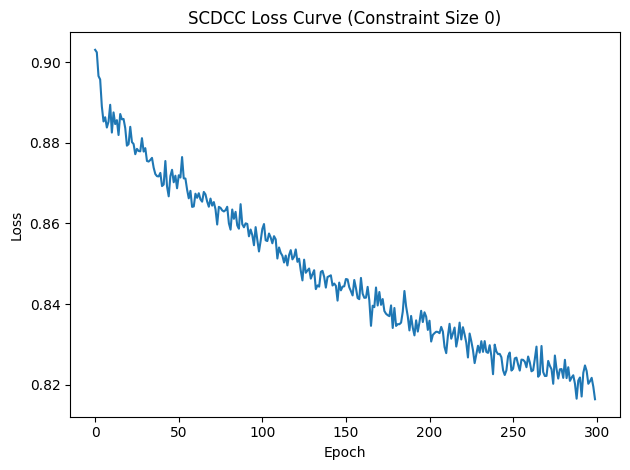

=== Visualizing constraint size: 0 ===


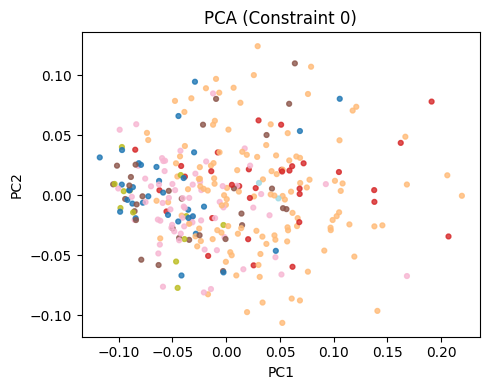

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


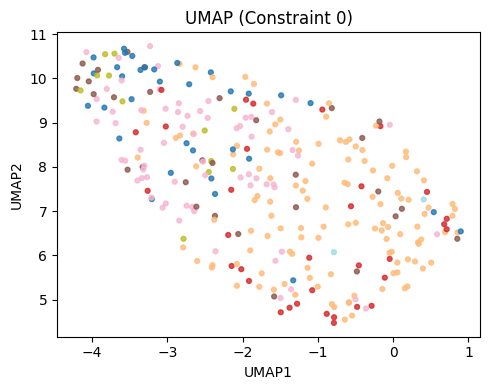

=== Visualizing constraint size: 1000 ===


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


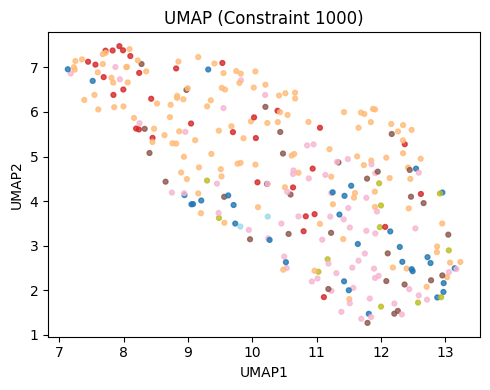

=== Visualizing constraint size: 2000 ===


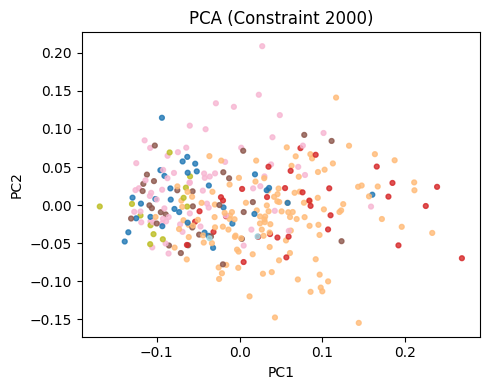

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


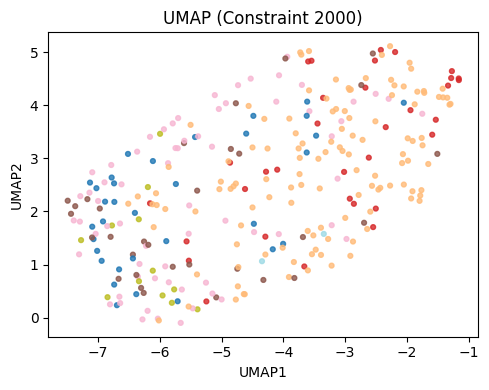

=== Visualizing constraint size: 3000 ===


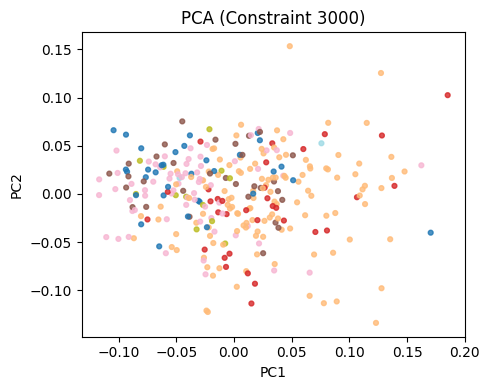

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


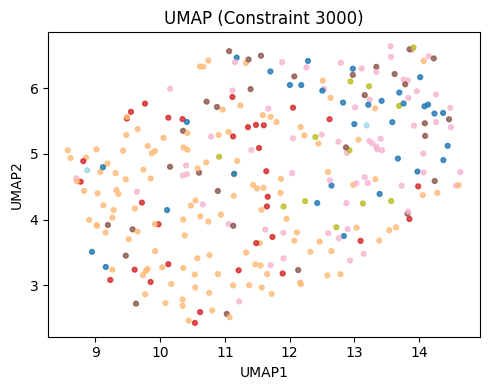

=== Visualizing constraint size: 4000 ===


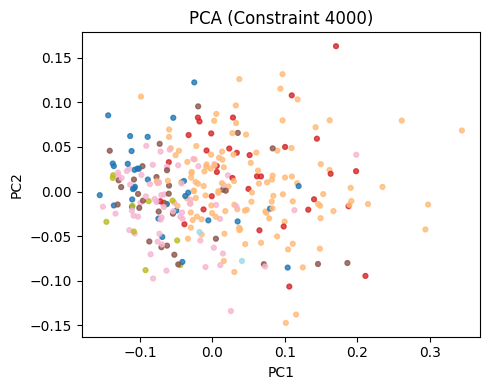

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


=== Visualizing constraint size: 5000 ===


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


=== Visualizing constraint size: 6000 ===


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


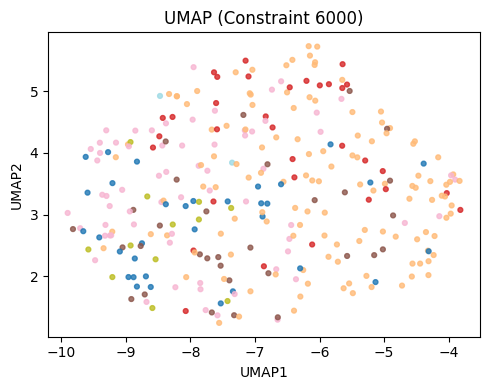

In [34]:

# Prepare arrays from AnnData objects -
X_train = adata_raw_train.X.astype(np.float32)
X_val   = adata_raw_val.X.astype(np.float32)
X_test  = adata_raw_test.X.astype(np.float32)

# Using factorize to map string labels to integer codes, and ensure consistent mapping
y_train, class_names = pd.factorize(adata_raw_train.obs["label"].astype(str).values)
y_val = pd.Categorical(adata_raw_val.obs["label"].astype(str).values, categories=class_names).codes
y_test = pd.Categorical(adata_raw_test.obs["label"].astype(str).values, categories=class_names).codes

print("Integer label mapping (use class_names[i] to get the cell type):")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

# Remaping constraints
cellname_to_idx = {name: i for i, name in enumerate(adata_raw_train.obs_names)}
def remap_pairs(pairs, mapping):
    return [(mapping[i], mapping[j]) for i, j in pairs if i in mapping and j in mapping]

constraints_idx = {
    size: {
        'must_link': remap_pairs(v['must_link'], cellname_to_idx),
        'cannot_link': remap_pairs(v['cannot_link'], cellname_to_idx)
    }
    for size, v in constraints.items()
}

#  Runing SCDCC 
middle_idx = len(constraints_idx) // 2
results = run_full_scdcc_pipeline(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    constraints_idx,
    latent_dims=[10, 20, 50],
    lrs=[1e-3, 5e-4],
    pretrain_epochs=300,
    train_epochs=300,
    n_repeats=10,
    alpha=1.0, beta=5.0, margin=2.0,
    tune_constraint_index=middle_idx
)

# Results
df = pd.DataFrame(results).T
display(df)

# Ploting ARI mean vs constraint size 
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.bar(df.index.astype(str), df["ARI_mean"], yerr=df["ARI_std"], alpha=0.7, label='ARI')
plt.title("SCDCC: ARI vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Mean ARI")
plt.tight_layout()
plt.show()

#  Ploting training loss curve 
first_size = list(results.keys())[0]
plt.plot(results[first_size]['loss_curves'][0])
plt.title(f'SCDCC Loss Curve (Constraint Size {first_size})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

#2D PCA/UMAP/Latent Visualization for Each Constraint Size 
from sklearn.decomposition import PCA
import umap

for size in results:
    print(f"=== Visualizing constraint size: {size} ===")
    # We'll just run a model again to get embeddings. You can save them during training if you want.
    model = scDCC(input_dim=X_train.shape[1], latent_dim=20).to(device)
    model.eval()
    with torch.no_grad():
        _, _, _, z_test = model(torch.tensor(X_test, dtype=torch.float32, device=device))
    z_test = z_test.cpu().numpy()

    # PCA
    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_pca[:,0], z_pca[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"PCA (Constraint {size})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    z_umap = reducer.fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_umap[:,0], z_umap[:,1], c=y_test, cmap='tab20', s=12, alpha=0.8)
    plt.title(f"UMAP (Constraint {size})")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.tight_layout()
    plt.show()


In [35]:
# For SCDCC, take the mean ± std from best constraint size:
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

# For KMeans and DEC, just use the single values:
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


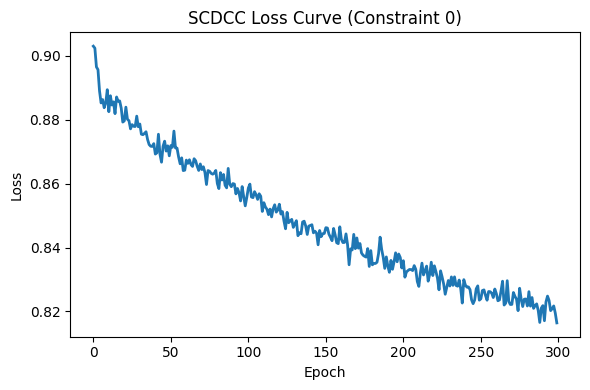

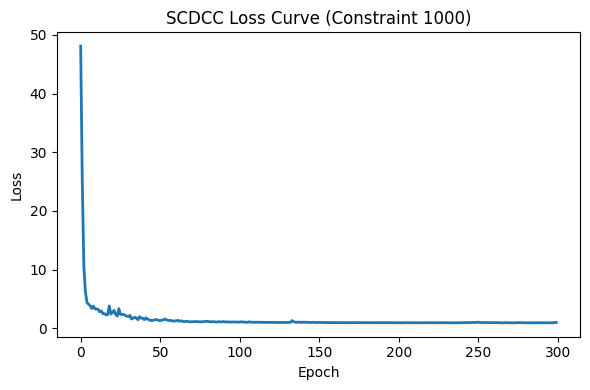

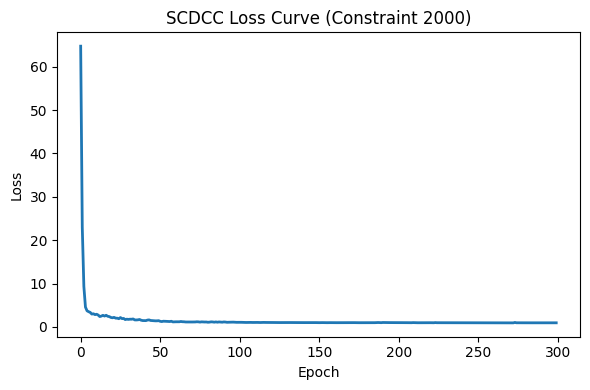

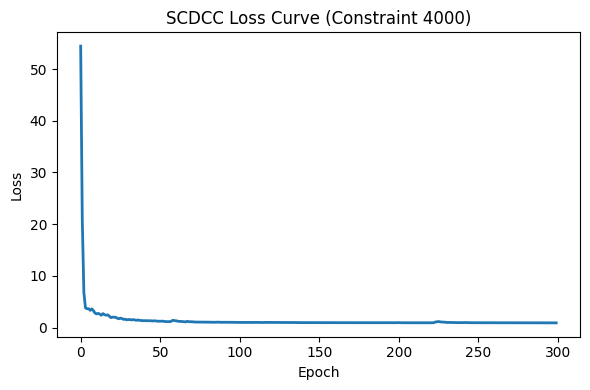

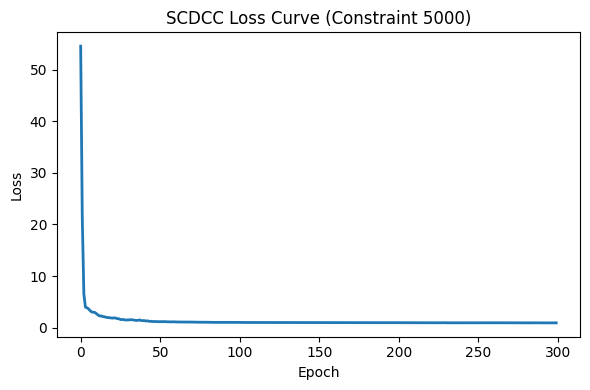

In [36]:
for size in results:
    loss_curve = results[size]['loss_curves'][0]  # first run, or loop for more
    plt.figure(figsize=(6,4))
    plt.plot(loss_curve, lw=2)
    plt.title(f"SCDCC Loss Curve (Constraint {size})")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()


In [37]:

#Plotting line graph
metrics = [
    ("ARI_mean", "ARI_std", "ARI"),
    ("NMI_mean", "NMI_std", "NMI"),
    ("CA_mean",  "CA_std",  "Clustering Accuracy"),
]

sizes = list(results.keys())
sizes_int = [int(s) for s in sizes]
sort_idx = np.argsort(sizes_int)
sorted_sizes = [sizes[i] for i in sort_idx]
size_ticks = [int(s) for s in sorted_sizes]

plt.figure(figsize=(10, 6))
for mean_key, std_key, display_name in metrics:
    means = [results[s][mean_key] for s in sorted_sizes]
    stds  = [results[s][std_key]  for s in sorted_sizes]
    plt.plot(size_ticks, means, marker='o', label=f"{display_name} (mean)")
    plt.fill_between(size_ticks,
                     np.array(means) - np.array(stds),
                     np.array(means) + np.array(stds),
                     alpha=0.15)

plt.title("SCDCC: ARI, NMI, CA vs Constraint Size")
plt.xlabel("Constraint Size")
plt.ylabel("Score")
plt.xticks(size_ticks)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


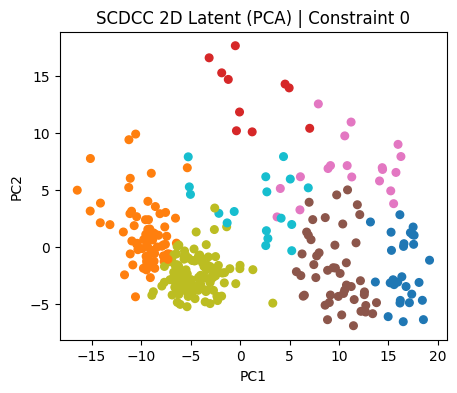

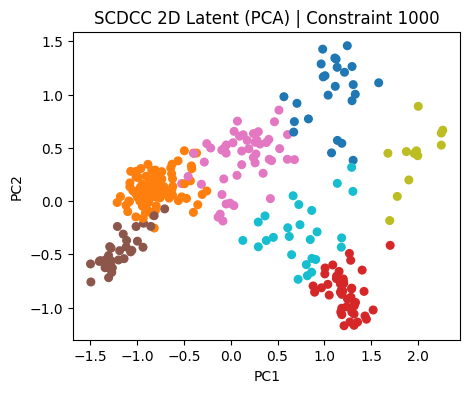

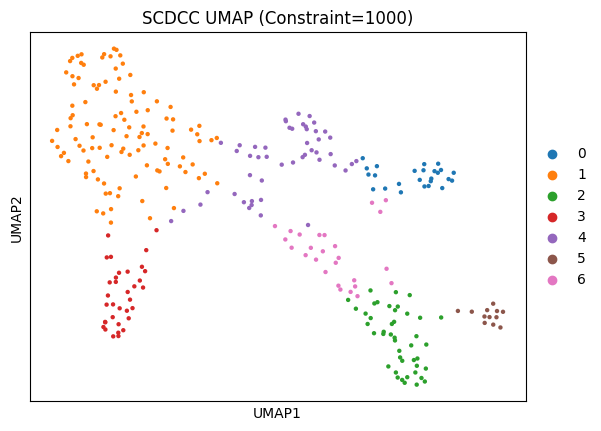

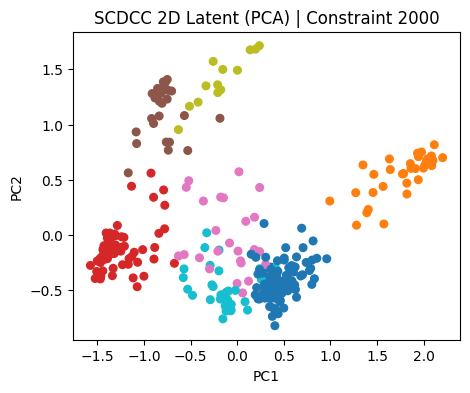

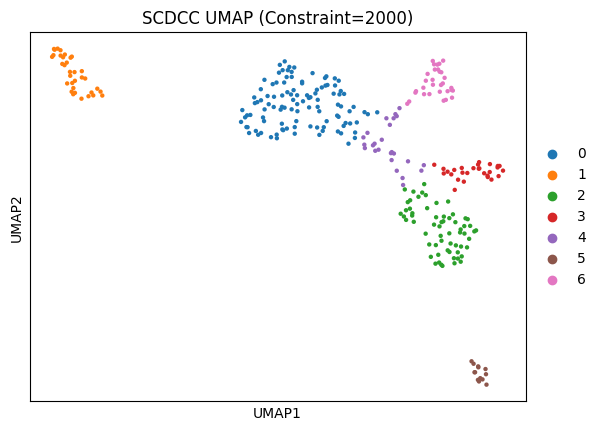

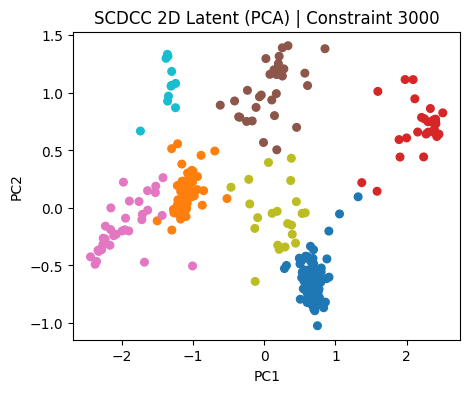

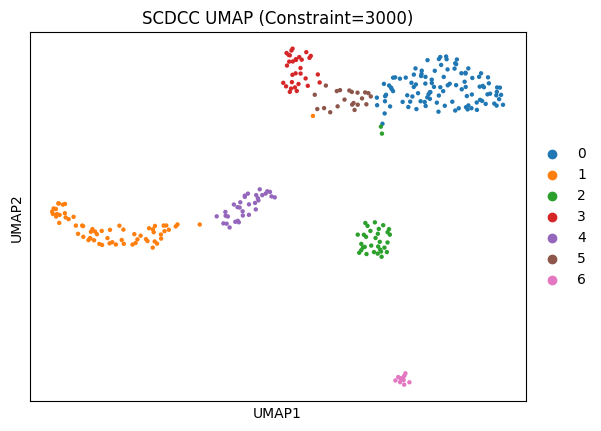

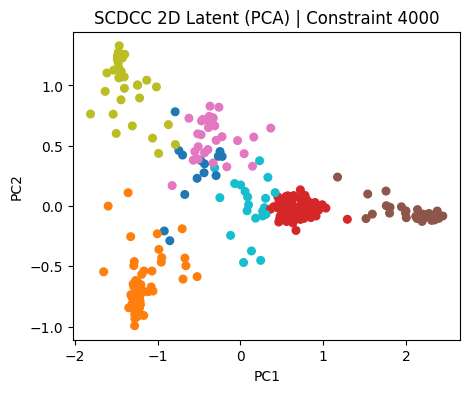

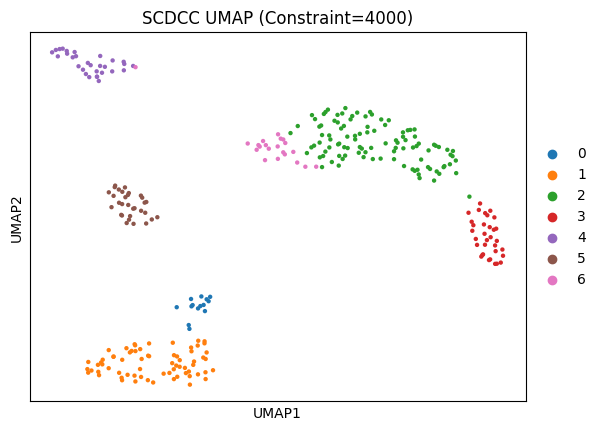

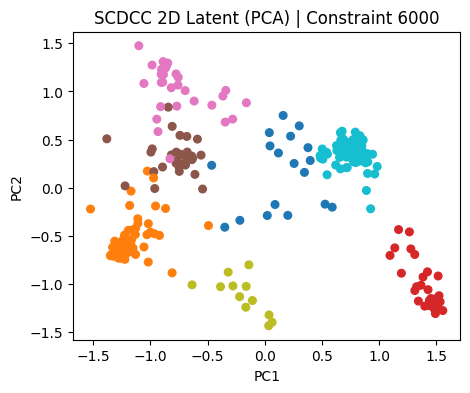

In [38]:

# For each constraint size,  2D PCA and UMAP for the first run
for size in results:
    z_test = results[size]['z_tests'][0]
    preds = results[size]['test_preds'][0]

    # 2D PCA
    z_2d = PCA(n_components=2).fit_transform(z_test)
    plt.figure(figsize=(5,4))
    plt.scatter(z_2d[:,0], z_2d[:,1], c=preds, cmap='tab10', s=30)
    plt.title(f"SCDCC 2D Latent (PCA) | Constraint {size}")
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()

    # UMAP
    adata = sc.AnnData(z_test)
    adata.obs['cluster'] = pd.Categorical(preds.astype(str))
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cluster', title=f"SCDCC UMAP (Constraint={size})", size=40)


In [39]:
#  SCDCC, taking the mean ± std from best constraint size:
best_size = max(results, key=lambda k: results[k]['ARI_mean'])
scdcc_ari = results[best_size]['ARI_mean']
scdcc_ari_std = results[best_size]['ARI_std']
scdcc_nmi = results[best_size]['NMI_mean']
scdcc_nmi_std = results[best_size]['NMI_std']
scdcc_ca = results[best_size]['CA_mean']
scdcc_ca_std = results[best_size]['CA_std']

#  KMeans and DEC values:
kmeans_ari = kmeans_results["ARI"]
kmeans_nmi = kmeans_results["NMI"]
kmeans_ca  = kmeans_results["CA"]

dec_ari = dec_results["ARI"]
dec_nmi = dec_results["NMI"]
dec_ca  = dec_results["CA"]


In [40]:

# bar plot for Kmeans,DEC and SCDCC Results
methods = ['KMeans', 'DEC', 'SCDCC']
ari_scores = [kmeans_ari, dec_ari, scdcc_ari]
ari_errs = [0, 0, scdcc_ari_std]  # only SCDCC has std (if you want to plot it)
nmi_scores = [kmeans_nmi, dec_nmi, scdcc_nmi]
nmi_errs = [0, 0, scdcc_nmi_std]
ca_scores = [kmeans_ca, dec_ca, scdcc_ca]
ca_errs = [0, 0, scdcc_ca_std]

x = np.arange(len(methods))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width, ari_scores, width, yerr=ari_errs, capsize=4, label='ARI')
plt.bar(x, nmi_scores, width, yerr=nmi_errs, capsize=4, label='NMI')
plt.bar(x + width, ca_scores, width, yerr=ca_errs, capsize=4, label='CA')
plt.xticks(x, methods)
plt.ylabel("Score")
plt.title("Comparison of KMeans, DEC, and SCDCC (Best Constraint Size)")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:

#Summary of KMeans ,DEC and SCDCC Results
summary = pd.DataFrame({
    'ARI': ari_scores,
    'NMI': nmi_scores,
    'CA': ca_scores
}, index=methods)

# Optionally include standard deviations
summary_std = pd.DataFrame({
    'ARI': ari_errs,
    'NMI': nmi_errs,
    'CA': ca_errs
}, index=methods)

print("=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===")
print(summary)
if any(s > 0 for s in ari_errs + nmi_errs + ca_errs):
    print("\n(Standard deviations where available):")
    print(summary_std)


=== Clustering Metrics Comparison (Best Constraint Size for SCDCC) ===
             ARI       NMI        CA
KMeans  0.458190  0.596592  0.644518
DEC     0.482984  0.655518  0.661130
SCDCC   0.875411  0.856997  0.922259

(Standard deviations where available):
             ARI       NMI        CA
KMeans  0.000000  0.000000  0.000000
DEC     0.000000  0.000000  0.000000
SCDCC   0.008927  0.011897  0.003388
